<a href="https://colab.research.google.com/github/davetew/Zero-Carbon-Aviation/blob/master/Zero_Carbon_Aviation_Colab_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Carbon Aircraft Propulsion and Energy Storage System Options
This notebook contains an assessment of the viability of several zero-carbon commerical aircraft combined energy storage and propulsion system options.

## Energy Storage
The energy storage options to be considered include--
1.   Batteries \\
    a.  [Lithium Ion](https://en.wikipedia.org/wiki/Lithium-ion_battery) \\
    b.  [Lithium Air](https://en.wikipedia.org/wiki/Lithium–air_battery)
    
2.   Fuels \\
    a.  Bio-Kerosene \\
    b.  Ammonia \\
    c.  Hydrogen
  

## Propulsion System
In this context, the propulsion system consists of the chemical to shaft power energy conversion system and the propulsor that converts the shaft power into aircraft thrust.

The chemical to shaft power propulsion system options that will be considered include--
1.  Open Brayton cycle gas turbines,
2.  Closed Brayton cycles (e.g. $sCO_{2}$ cycles),
3.  Fuel cells with electric motors,
4.  Batteries with electric motors, and
5.  Hybrid cycles using the above technologies that leverage both fuel and battery energy storage systems.

The propulsor options that will be considered include--
1.  Ducted fans, and
2.  Unducted fans.

In [1]:
"""Import the typical Python modules"""
import numpy as np
from scipy import constants
!pip install pandas==1.1.0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%config InlineBackend.figure_format = 'retina'

import requests
from io import BytesIO

from IPython.display import Markdown

from google.colab import files
from IPython.display import Image

In [2]:
"""Install, import, and configure 'pint' -- a physical quantity manipulation package"""
!pip install pint
#!python -m pip install git+https://github.com/hgrecco/pint-pandas.git

import pint

# Save default unit registry in ureg & Quantity in Q_
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Define a currency dimension with usd (US dollar) as the base unit
ureg.define('usd = [currency]')

# Define a passenger dimension with passengers as the base unit
ureg.define('passenger = [passenger]')

# Ignore pint unit strip warnings
import warnings
warnings.filterwarnings("ignore", message="The unit of the quantity is stripped.")

In [3]:
# Install Cantera
%%capture

# New cantera
!apt-add-repository -y ppa:cantera-team/cantera
!apt-get update
!apt install -y cantera-python3

# Quick fix to enable bionic version of cantera to work with python 3.7 on colab (probably required as long as Ubuntu is version 18.04)
!cp /usr/lib/python3/dist-packages/cantera/_cantera.cpython-36m-x86_64-linux-gnu.so /usr/lib/python3/dist-packages/cantera/_cantera.so

import cantera as ct

In [4]:
"""Define fuel property classes"""

class Fuel:
    """Fuel specification class"""
    def __init__(self, phase_definition=None, 
                 specific_cost=None,
                 liquid_density=None,
                 stored_mass_fraction=1):
      
        self.phase_definition = phase_definition
        self.phase = ct.Solution(source=phase_definition)
        self.specific_cost = specific_cost
        self.liquid_density = liquid_density
        self.stored_mass_fraction = stored_mass_fraction
    
    @property
    def cost_liquid_volume_specific(self, unit_string='usd/liter'):
      """Calculate and return the liquid volume specific cost"""
      if self.specific_cost.to_base_units().units == ureg['usd/meters**3']:
        
        # Input specfic cost is already liquid volume specific - convert to specified units
        return self.specific_cost.to(ureg[unit_string])
      
      elif self.specific_cost.to_base_units().units == ureg['usd/kg']:
        
        # Input specific cost is mass-specific - calculate & return volumetric cost
        return (self.specific_cost * self.liquid_density).to(ureg[unit_string])
 
    @property
    def cost_mass_specific(self, unit_string='usd/kg'):
      """Calculate and return the mass specific cost"""
      if self.specific_cost.to_base_units().units == ureg['usd/kg']:
        
        # Input specfic cost is already mass specific - convert to specified units
        return self.specific_cost.to(ureg[unit_string])
      
      elif self.specific_cost.to_base_units().units == ureg['usd/meters**3']:
        
        # Input specific cost is volume-specific - calculate & return mass-specific cost
        return (self.specific_cost / self.liquid_density).to(ureg[unit_string])
        
    @property
    def lower_heating_value(self):
      """Calculate and return the lower heating value"""
      
      # Specify the reactant state
      reactants = ct.Solution(source=self.phase_definition)
      reactants.TP = 298, ct.one_atm
      reactants.set_equivalence_ratio(1.0, self.phase.name, 'O2:1.0')
      
      # Calculate the fuel mass fraction
      Y_fuel = reactants[self.phase.name].Y[0]
      
      # Complete combustion product mole fractions
      X_products = {'CO2': reactants.elemental_mole_fraction('C'),
                    'H2O': 0.5 * reactants.elemental_mole_fraction('H'),
                    'N2': 0.5 * reactants.elemental_mole_fraction('N')}
      
      # Calculate the product enthalpy at 298 K, 1 atm
      products = ct.Solution(source=self.phase_definition)
      products.TPX = 298, ct.one_atm, X_products
      
      return Q_( (reactants.enthalpy_mass - products.enthalpy_mass) / Y_fuel,
                ureg['J/kg'] )
      
    @property
    def stored_lower_heating_value(self):
      return self.lower_heating_value * self.stored_mass_fraction
    
    @property
    def cost_energy_specific(self, unit_string='usd/kWh'):
        """Calculate the energy-specific cost of fuel on a lower-heating-value basis."""
        return (self.cost_mass_specific / self.lower_heating_value).to(ureg[unit_string])
      
    @property
    def emissions_factor(self, unit_string='kg/kWh'):
      """Calculate the LHV-specific CO2 emisions factor (eg. kg CO2/kWh)"""
      
      # Specify the reactant state
      reactants = ct.Solution(source=self.phase_definition)
      reactants.TP = 298, ct.one_atm
      reactants.set_equivalence_ratio(1.0, self.phase.name, 'O2:1.0')
      
      if reactants.elemental_mole_fraction('C') == 0:
        return 0*ureg[unit_string]
      
      else:
        
        # Calculate the fuel mass fraction
        Y_fuel = reactants[self.phase.name].Y[0]

        # Complete combustion product mole fractions
        X_products = {'CO2': reactants.elemental_mole_fraction('C'),
                      'H2O': 0.5 * reactants.elemental_mole_fraction('H'),
                      'N2': 0.5 * reactants.elemental_mole_fraction('N')}

        # Calculate the product enthalpy at 298 K, 1 atm
        products = ct.Solution(source=self.phase_definition)
        products.TPX = 298, ct.one_atm, X_products

        return ( products['CO2'].Y[0] / Y_fuel / 
                 self.lower_heating_value ).to(ureg[unit_string])
    
 
class Methane(Fuel):
    """Methane per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(0.25, ureg['usd/kg'])):
      
      # Fuel name
      self.name = 'Methane'
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='CH4',
                        elements='C O H N',
                        species='nasa_gas:CH4 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(423, ureg['kg/meter**3']))
      
class JetA(Fuel):
    """Jet Fuel per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(1.4, ureg['usd/liter'])):
      
      # Fuel name
      self.name = 'Jet-A'
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='Jet-A(g)',
                        elements='C O H N',
                        species='nasa_gas:Jet-A(g) H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(804, ureg['kg/meter**3']))

class Ammonia(Fuel):
    """Ammonia per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(500, ureg['usd/tonne'])):
      
      # Fuel name
      self.name = 'Ammonia'
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='NH3',
                        elements='C O H N',
                        species='nasa_gas:NH3 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(682, ureg['kg/meter**3']))    

class Hydrogen(Fuel):
    """Hydrogen per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(4, ureg['usd/kg']), 
                 stored_mass_fraction=1):
      
      self.name = 'Hydrogen'
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='H2',
                        elements='C O H N',
                        species='nasa_gas:H2 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(71, ureg['kg/meter**3']),
                    stored_mass_fraction=stored_mass_fraction) 
      
class Ethanol(Fuel):
    """Ethanol per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(1.74, ureg['usd/gallon'])):
      
      # Fuel name
      self.name = 'Ethanol'
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='C2H5OH',
                        elements='C O H N',
                        species='nasa_gas:C2H5OH H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(789, ureg['kg/meter**3']))  

## Specific Energy of Potential Energy Storage Media
Several classes of energy storage media will be at least superficially considered.  These include--

1. Traditional batteries
2. Metal-air batteries
3. Liquid fuels


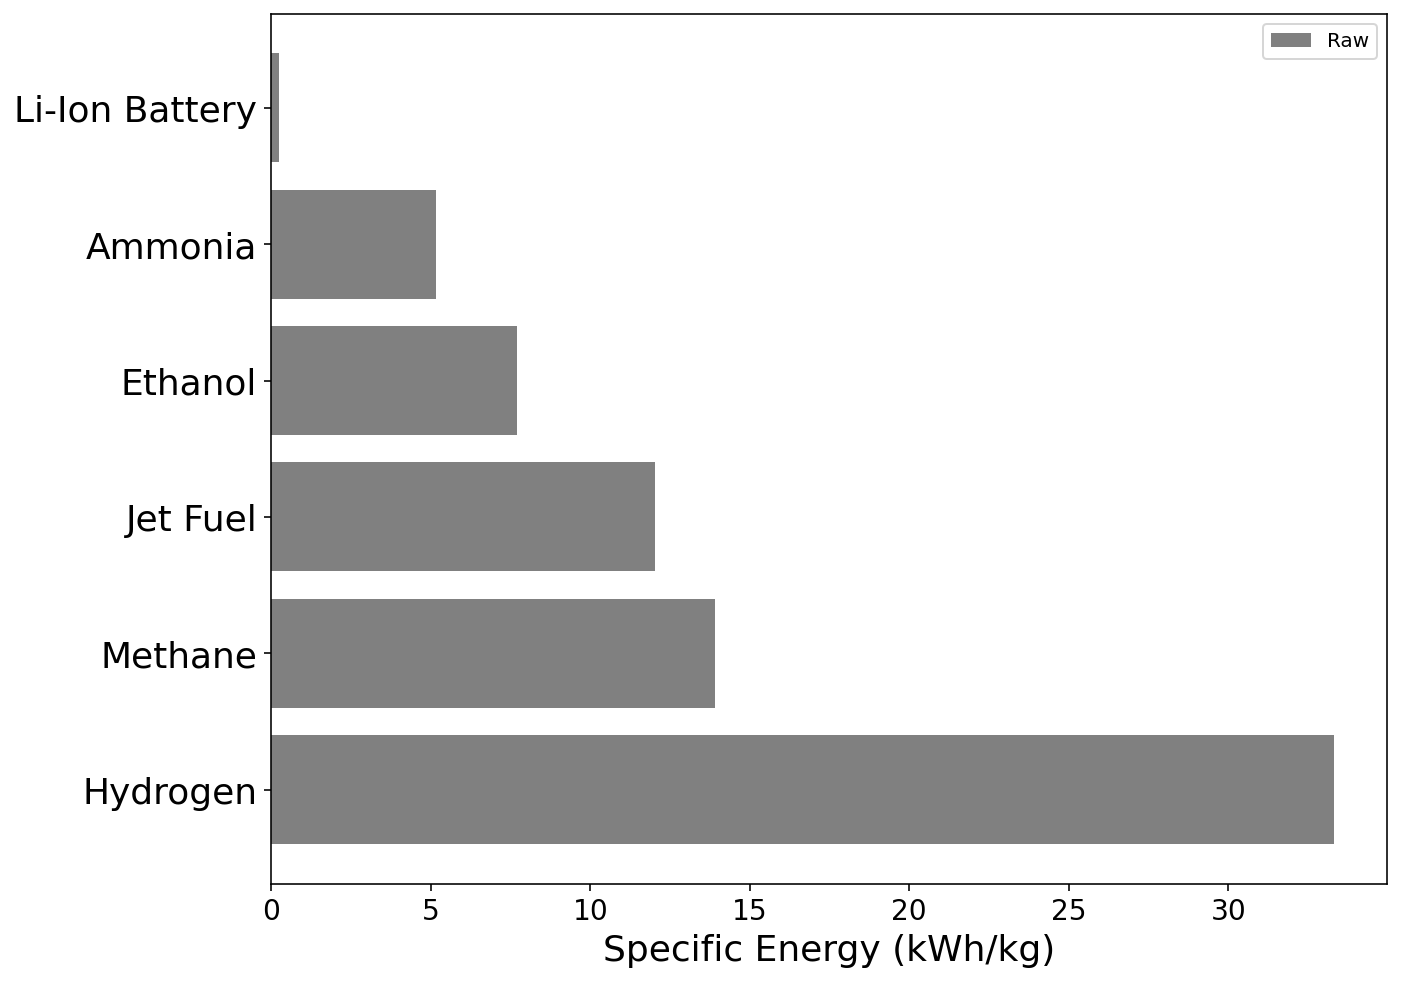

In [7]:
#@title Storage Media Specific Energy
"""Record and plot the mass specific energies of a range of storage media"""

# Raw specific energies for various energy storage options
specific_energy_Wh_kg = {'Li-Ion Battery': 250*ureg['Wh/kg'],
                        'Ammonia': Ammonia().lower_heating_value.to(ureg['Wh/kg']),
                        'Ethanol': Ethanol().lower_heating_value.to(ureg['Wh/kg']),
                        'Jet Fuel': JetA().lower_heating_value.to(ureg['Wh/kg']),
                        'Methane': Methane().lower_heating_value.to(ureg['Wh/kg']),
                        'Hydrogen': Hydrogen().lower_heating_value.to(ureg['Wh/kg'])}

y_lab = specific_energy_Wh_kg.keys()
y_pos = np.arange(len(y_lab))
y_val = [y.magnitude/1000 for y in specific_energy_Wh_kg.values()]

specific_energy = pd.DataFrame(data=y_val, columns=['Raw (kWh/kg)'], index=y_lab)
specific_energy['Stored Mass Fraction'] = [1.0, 0.9, 0.6, 0.9, 0.9, 0.1]
specific_energy['Conversion Efficiency'] = [0.8, 0.35, 0.35, 0.35, 0.35, 0.35]


for medium in specific_energy.index:
  md = specific_energy.loc[medium]
  specific_energy.loc[medium,'Effective (kWh/kg)'] = ( md['Raw (kWh/kg)'] * 
                                                     md['Stored Mass Fraction'] *
                                                     md['Conversion Efficiency'] )
  specific_energy.loc[medium,'Delta (kWh/kg)'] = md['Raw (kWh/kg)'] - specific_energy.loc[medium,'Effective (kWh/kg)']

#display(specific_energy)

fig, ax = plt.subplots(figsize=(10,8))

ax.barh(y_pos, y_val, align='center', color='gray', label='Raw')
ax.set_yticks(y_pos)
ax.set_yticklabels(specific_energy_Wh_kg.keys(), fontsize=18)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Specific Energy (kWh/kg)', fontsize=18)
#ax.set_title('Chemical Storage Options w/o Storage Vessel', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.legend()
plt.show()

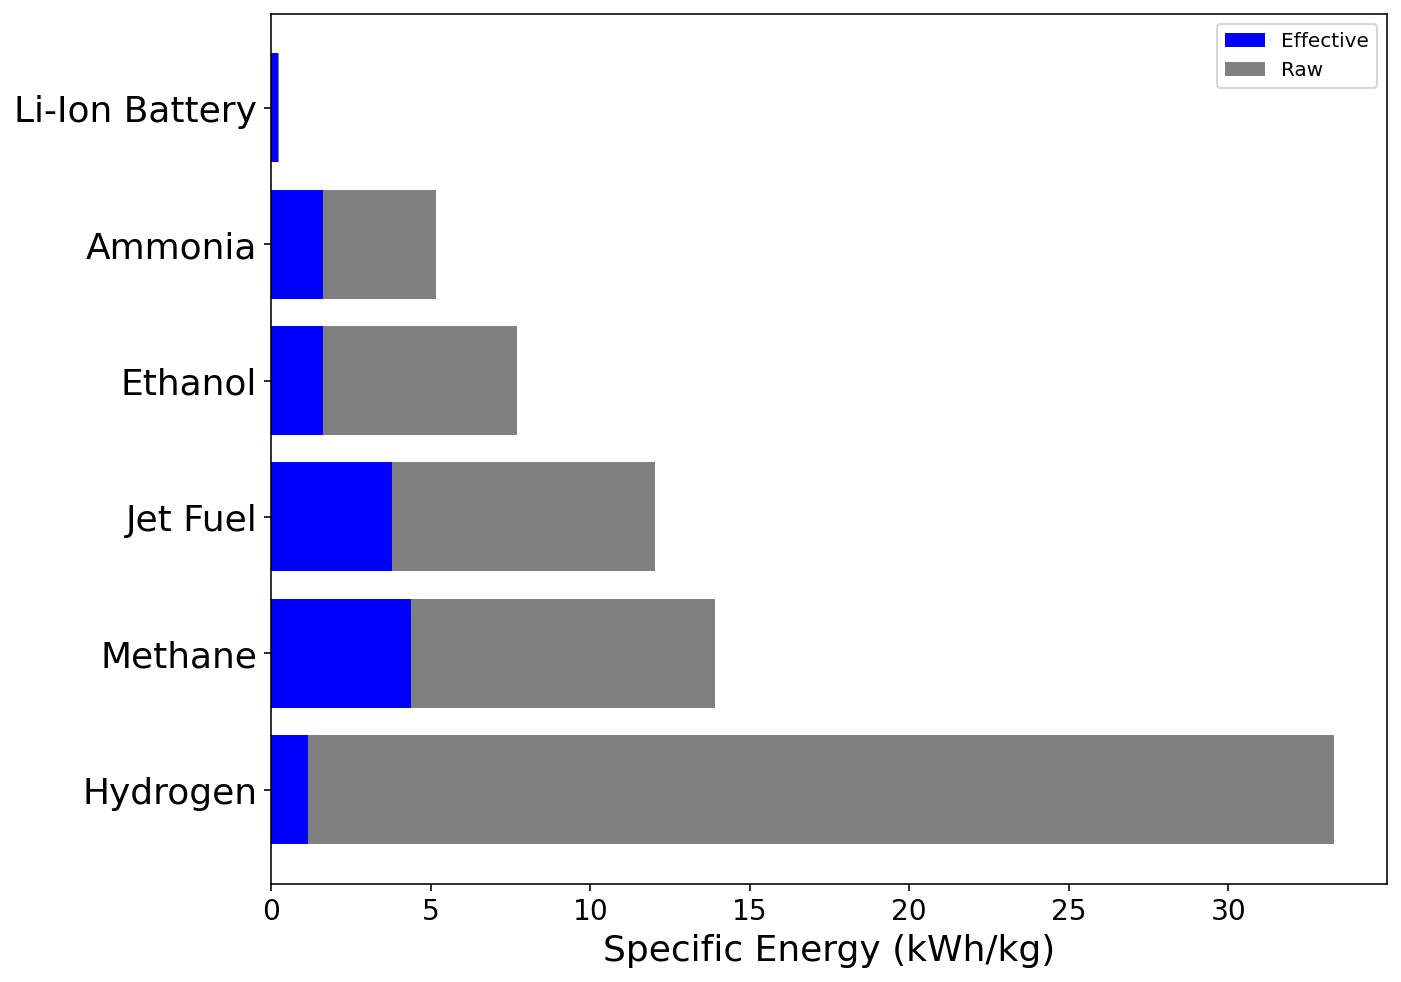

In [8]:
#@title Effective Specific Energy of Storage Media
fig, ax = plt.subplots(figsize=(10,8))

ax.barh(y_pos, specific_energy['Effective (kWh/kg)'], align='center', color='blue', label='Effective')
ax.barh(y_pos, specific_energy['Delta (kWh/kg)'], align='center', color='gray', 
        label='Raw', left=specific_energy['Effective (kWh/kg)'])
ax.set_yticks(y_pos)
ax.set_yticklabels(specific_energy_Wh_kg.keys(), fontsize=18)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Specific Energy (kWh/kg)', fontsize=18)
#ax.set_title('Chemical Storage Options w/o Storage Vessel', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.legend()
plt.show()

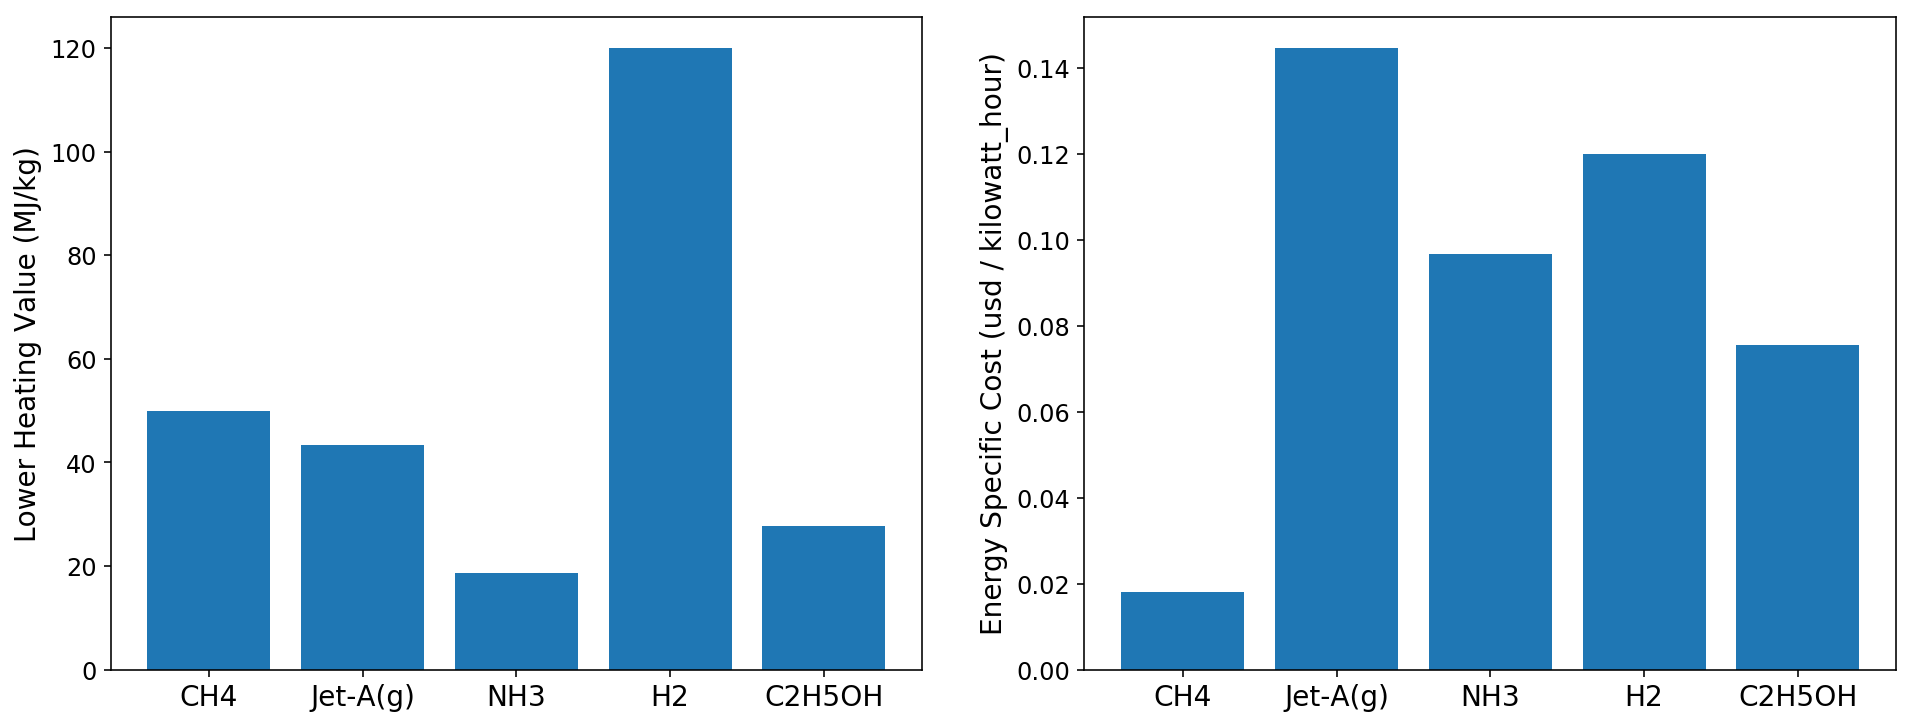

In [ ]:
#@title Chemical Storage Media Mass-Specific Energy & Energy-Specific Cost

# Natural gas cost
energy_specific_cost = Q_(5/1.037*1.1/1e6, ureg['usd/Btu'])
mass_specific_cost = ( energy_specific_cost * 50*ureg['MJ/kg'] ).to(ureg['usd/kg'])

ch4 = Methane(specific_cost=mass_specific_cost)

bioK = JetA()

nh3 = Ammonia()

h2 = Hydrogen()

c2h5oh = Ethanol()

fuels = [ch4, bioK, nh3, h2, c2h5oh]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
ind = np.arange(1,len(fuels)+1)

ax1.bar(ind, [fuel.lower_heating_value.to('MJ/kg').magnitude for fuel in fuels])
ax1.set_xticks(ind)
ax1.set_xticklabels([fuel.phase.name for fuel in fuels], fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('Lower Heating Value (MJ/kg)', fontsize=14)

ax2.bar(ind, [fuel.cost_energy_specific.magnitude for fuel in fuels])
ax2.set_xticks(ind)
ax2.set_xticklabels([fuel.phase.name for fuel in fuels], fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel(f'Energy Specific Cost ({fuels[0].cost_energy_specific.units})', fontsize=14)

plt.show()

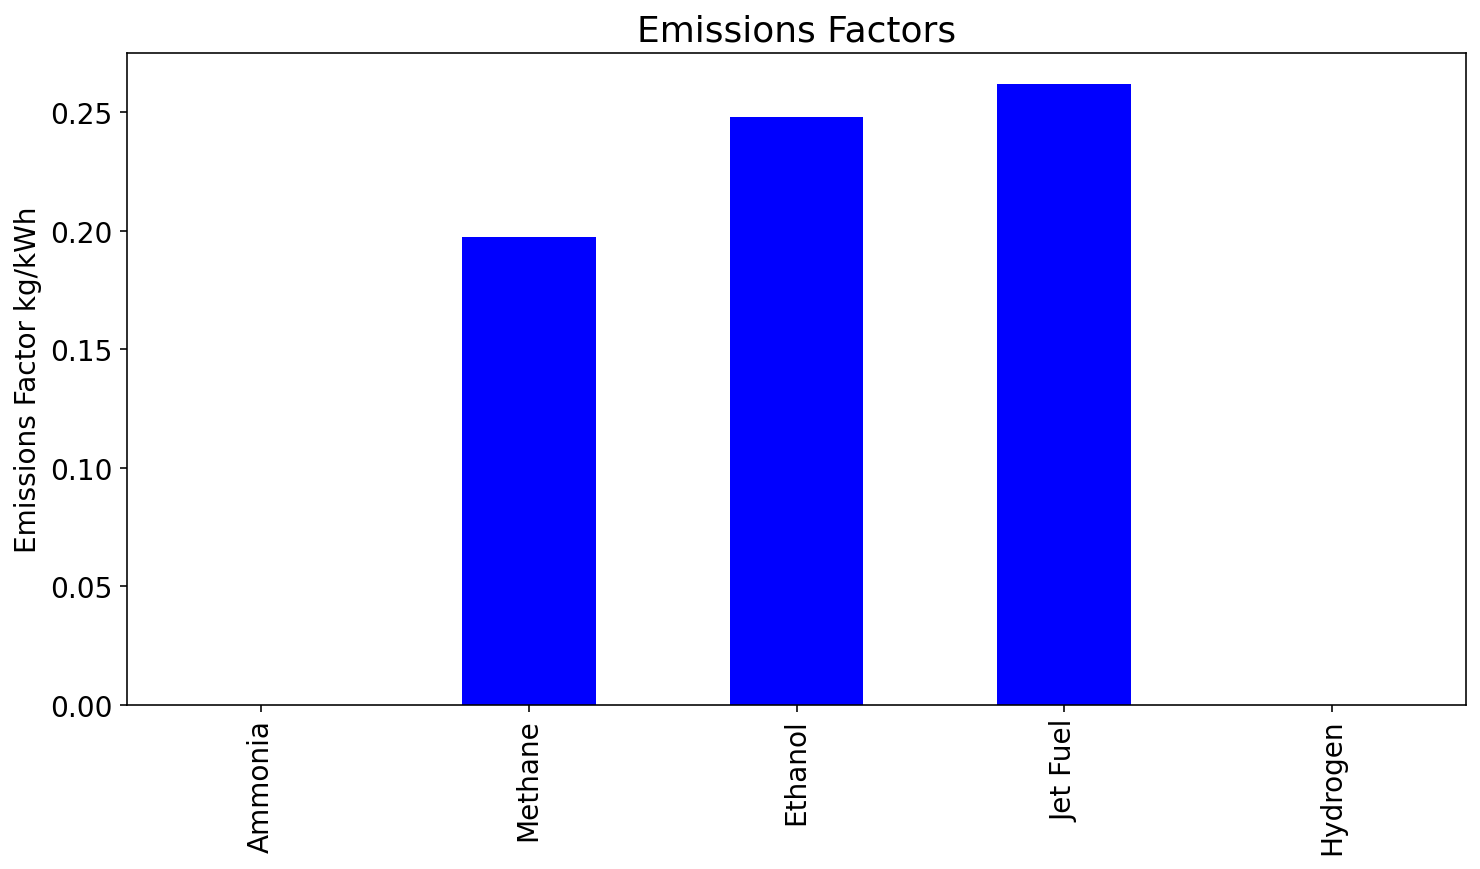

In [9]:
#@title Storage Media LHV-Basis Emissions Factor (e.g. kg CO2/kWh)
"""Record and plot the energy-specific CO2 emissions"""

EF_units = 'kg/kWh'

EmissionsFactors = {'Ammonia': Ammonia().emissions_factor.to(ureg[EF_units]).magnitude,
                    'Methane': Methane().emissions_factor.to(ureg[EF_units]).magnitude,
                    'Ethanol': Ethanol().emissions_factor.to(ureg[EF_units]).magnitude,
                    'Jet Fuel': JetA().emissions_factor.to(ureg[EF_units]).magnitude,
                    'Hydrogen': Hydrogen().emissions_factor.to(ureg[EF_units]).magnitude}


StorageMediaEmissionsFactor = pd.DataFrame.from_dict(EmissionsFactors, orient='index', columns=['Emissions Factor'])

#display(StorageMediaEmissionsFactor)

# Chemical Storage Options w/o Storage Vessel
ax=StorageMediaEmissionsFactor.loc['Ammonia':'Hydrogen'].plot.bar(figsize=(12,6), legend=False, color='b', fontsize=14)
ax.set_ylabel(f'Emissions Factor {EF_units}', fontsize=14);
ax.set_title('Emissions Factors', fontsize=18);

## Aircraft Performance Data

Performance data for 'representative' aircraft from four different aircraft classes are stored in the JSON-format-like `AircraftData` dictionary.  These aircraft include the following commercial aircraft--
1.  A turboprop [Bomardier Dash 8-Q400](https://en.wikipedia.org/wiki/Bombardier_Dash_8),
2.  A regional jet [Airbus A220-300](https://www.airbus.com/aircraft/passenger-aircraft/a220-family/a220-300.html),
3.  A single aisle [Boeing 737 MAX 8](https://en.wikipedia.org/wiki/Boeing_737_MAX), and
4.  A twin aisle [Boeing 777X](https://en.wikipedia.org/wiki/Boeing_777X).

The data provided include the following types of information--
1. Weight,
2. Wing geometry,
3. Cruise speed and/or Mach number,
3. Payload (fuel & passengers),
4. Cost,
5. Engines.

More detailed information on these characteristics is provided below.

### Weight
When available, four different weights are recorded within the dictionary.  These weight include--
1. Maximum Gross Take-Off Weight ($MTOW$),
2. Maximum Zero Fuel Weight ($MZFW$),
3. Operating Empty Weight ($OEW$), and
4. Maximum Landing Weight ($MLW$),

$MTOW$ is the maximum authorized weight at brake release.  $TOW$ is the actual take-off weight, which may be calculated from the below expression.

$$TOW = OEW + PL + FW$$

$$TOW \leq MTOW$$

$PL$ is the payload weight, and $FW$ is the fuel weight.  $OEW$ is the operating empty weight of the aircraft; it includes the weight of the aircraft structure ($SW$) and the weight of the propulsion system ($PW$)--

$$OEW = SW + PW$$

$MZFW$ is the maximum aircraft weight before fuel and other consumable propulsion system agents are loaded onto the aircraft.

$$MZFW = OEW + PL_{max}$$

$PL_{max}$ is the maximum payload.

In this context, the payload weight ($PL$) includes passengers, luggage, cargo, crew, food, beverages and related supplies.  Also, the fuel weight ($FW$) is assumed to include all propulsion-related consumables (e.g. fuel, oil).

For purposes of the propulsion and energy storage system analyses anticipated in this notebook, the aircraft considered will be assumed to take-off at their maximum take-off weight ($MTOW$) with their maximum payloads ($PL_{max}$). 

\begin{align}
MTOW & = OEW + PL_{max} + FW \\
& = SW + PW + PL_{max} + FW \\
& = SW + PL_{max} + PW + FW
\end{align}

The maximum payload is calculated from the available $MZFW$ and $OEW$ data--

$$PL_{max} = MZFW - OEW$$

Also, the fuel weight will be calculated from the available $MTOW$ and $OEW$ and the calculated $PL_{max}$.

$$FW = MTOW - OEW - PL_{max}$$

The propulsion system weight ($PW$) will be estimated from the engine data contained within the dictionary.  However, this weight is likely an underestimate of the weight as it is likely not inclusive of the engine nacelle and pylon.


In [10]:
def clean_data(dirty_df):
  """Clean up dataframe read from csv file whose first column was used as the index, and
  the individual indicies contained the quantity name and the units in parenthesis.
  
  The clean up process involves first converting the numeric cells from strings 
  and then converting the floats to "pint" physical quantities using the units provided."""
  
  def convert_numbers_to_floats(df):
    """Convert numeric values in the input data frame to floats"""
    
    def is_float(input):
      """Check to see if an input string contains a float"""
      try:
        num = float(input)
      except ValueError:
        return False
      return True
    
    return df.applymap(lambda x: float(x.replace(",","")) 
                       if isinstance(x, str) and is_float(x.replace(",",""))
                       else x)
  
  def get_units_and_create_new_indices(df):
    """Get physical units from portions of index strings that are between ( ) and
    remove the unit specification from the index strings to create simpler indices"""
    
    unit_strings = []; new_indices = []
    for index, row in df.iterrows():
  
      if index.find("(") == -1:
        unit_strings.append("")
        new_indices.append(index)
      else:    
        unit_strings.append(index[index.find("(")+1:index.find(")")])
        new_indices.append(index[0:index.find("(")-1])
        
    return unit_strings, new_indices
  
  # Convert numbers to floats
  clean_df = convert_numbers_to_floats(dirty_df)
  
  # Get units & new indices
  unit_strings, new_indices = get_units_and_create_new_indices(clean_df)
  
  # Switch to new indices
  # clean_df.reindex(new_indices)
  clean_df['Parameters'] = new_indices
  clean_df.set_index('Parameters', inplace=True)
  
  # Add units (i.e. create pint Quantities) for numeric values with physical units
  for unit_string, parameter in zip(unit_strings, clean_df.index.values.tolist()):
    for column in clean_df.columns:
      if isinstance(clean_df.loc[parameter, column], float) and not( unit_string == ""):
        clean_df.loc[parameter, column] = clean_df.loc[parameter, column] * ureg(unit_string)
  
  return clean_df

In [11]:
"""Load aircraft data"""

# Get data from Google spread sheet on Dave's G Drive
rawACData = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vSA_H7NEvMSQTltN4FRqKaJ-8uWw_bDHwP2WarH4PzRh8Qm3IOajMyOMxhZ1hzv9Ui-tXKjMt9KhvuY/pub?gid=0&single=true&output=csv')

# Save the data in a pandas data frame
AircraftData = clean_data(pd.read_csv(BytesIO(rawACData.content), index_col=0, thousands=r","))

# Get list of aircraft represented in data frame
Aircraft = AircraftData.columns

# Calculate the max payload and fuel weights for the varoious aircraft and append them to the dataframe
AircraftData.loc['Max Payload Weight'] = AircraftData.loc['Max Zero Fuel Weight'] - AircraftData.loc['Operating Empty Weight']

AircraftData.loc['Fuel Weight'] = ( AircraftData.loc['Max Take Off Weight'] - 
                                    AircraftData.loc['Operating Empty Weight'] - 
                                    AircraftData.loc['Max Payload Weight'] )

display(AircraftData)

,Dash-8-Q400,A220-300,737 MAX 8,767-300ER,777-9X,Concorde
Parameters,,,,,,
Max Take Off Weight,29260.0 kilogram,67600.0 kilogram,82191.0 kilogram,186880.0 kilogram,351500.0 kilogram,185066.0 kilogram
Max Landing Weight,28010.0 kilogram,58700.0 kilogram,69309.0 kilogram,nan kilogram,266000.0 kilogram,nan kilogram
Max Zero Fuel Weight,25850.0 kilogram,55800.0 kilogram,65952.0 kilogram,133810.0 kilogram,255000.0 kilogram,89386.0 kilogram
Operating Empty Weight,17110.0 kilogram,37081.0 kilogram,45070.0 kilogram,90011.0 kilogram,181400.0 kilogram,78698.0 kilogram
Cruise Mach,NaN,0.82,0.79,NaN,NaN,2.04
Cruise Speed,667.0 kilometer / hour,829.0 kilometer / hour,839.0 kilometer / hour,850.0 kilometer / hour,900.0 kilometer / hour,2157.0 kilometer / hour
Wing Area,63.1 meter ** 2,112.3 meter ** 2,127.0 meter ** 2,283.3 meter ** 2,466.8 meter ** 2,358.2 meter ** 2
Wing Span,28.4 meter,35.1 meter,35.92 meter,47.57 meter,71.8 meter,25.6 meter
Fuel Capacity,6530.0 liter,21918.0 liter,25817.0 liter,91380.0 liter,198000.0 liter,119005.0 liter


In [12]:
"""Load Engine Data"""
rawEngData = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ5-u7udgzqZoPJy4Ao6RTlmFTSbg3_71hMCk9AkI_x1yTCiGVxs4ltPtdKUrMduxsepPMq6e0QzaCz/pub?gid=0&single=true&output=csv')
EngineData = clean_data(pd.read_csv(BytesIO(rawEngData.content), index_col=0))
display(EngineData)

,PW150A,PW1500G,CFM LEAP 1B,GE-CF6-80C2,GE9X-105B1A,Olympus 593
Parameters,,,,,,
Type,Turboprop,Turbofan,Turbofan,Turbofan,Turbofan,Turbojet
OPR,NaN,NaN,40,31.8,61,82
BPR,NaN,12,9,5.31,10,0
TSFC,nan gram / kilonewton / second,nan gram / kilonewton / second,15.5 gram / kilonewton / second,9.0 gram / kilonewton / second,nan gram / kilonewton / second,33.8 gram / kilonewton / second
Cruise TSFC,nan gram / kilonewton / second,nan gram / kilonewton / second,nan gram / kilonewton / second,16.75 gram / kilonewton / second,nan gram / kilonewton / second,33.8 gram / kilonewton / second
Take Off TSFC,nan gram / kilonewton / second,nan gram / kilonewton / second,nan gram / kilonewton / second,9.5 gram / kilonewton / second,nan gram / kilonewton / second,39.0 gram / kilonewton / second
Fan Diameter,nan meter,1.85 meter,1.76 meter,2.69 meter,3.39 meter,nan meter
Weight,716.9 kilogram,2177.0 kilogram,2780.0 kilogram,4470.0 kilogram,18182.0 kilogram,3175.0 kilogram
Cost,nan megausd,12.0 megausd,14.5 megausd,nan megausd,nan megausd,nan megausd


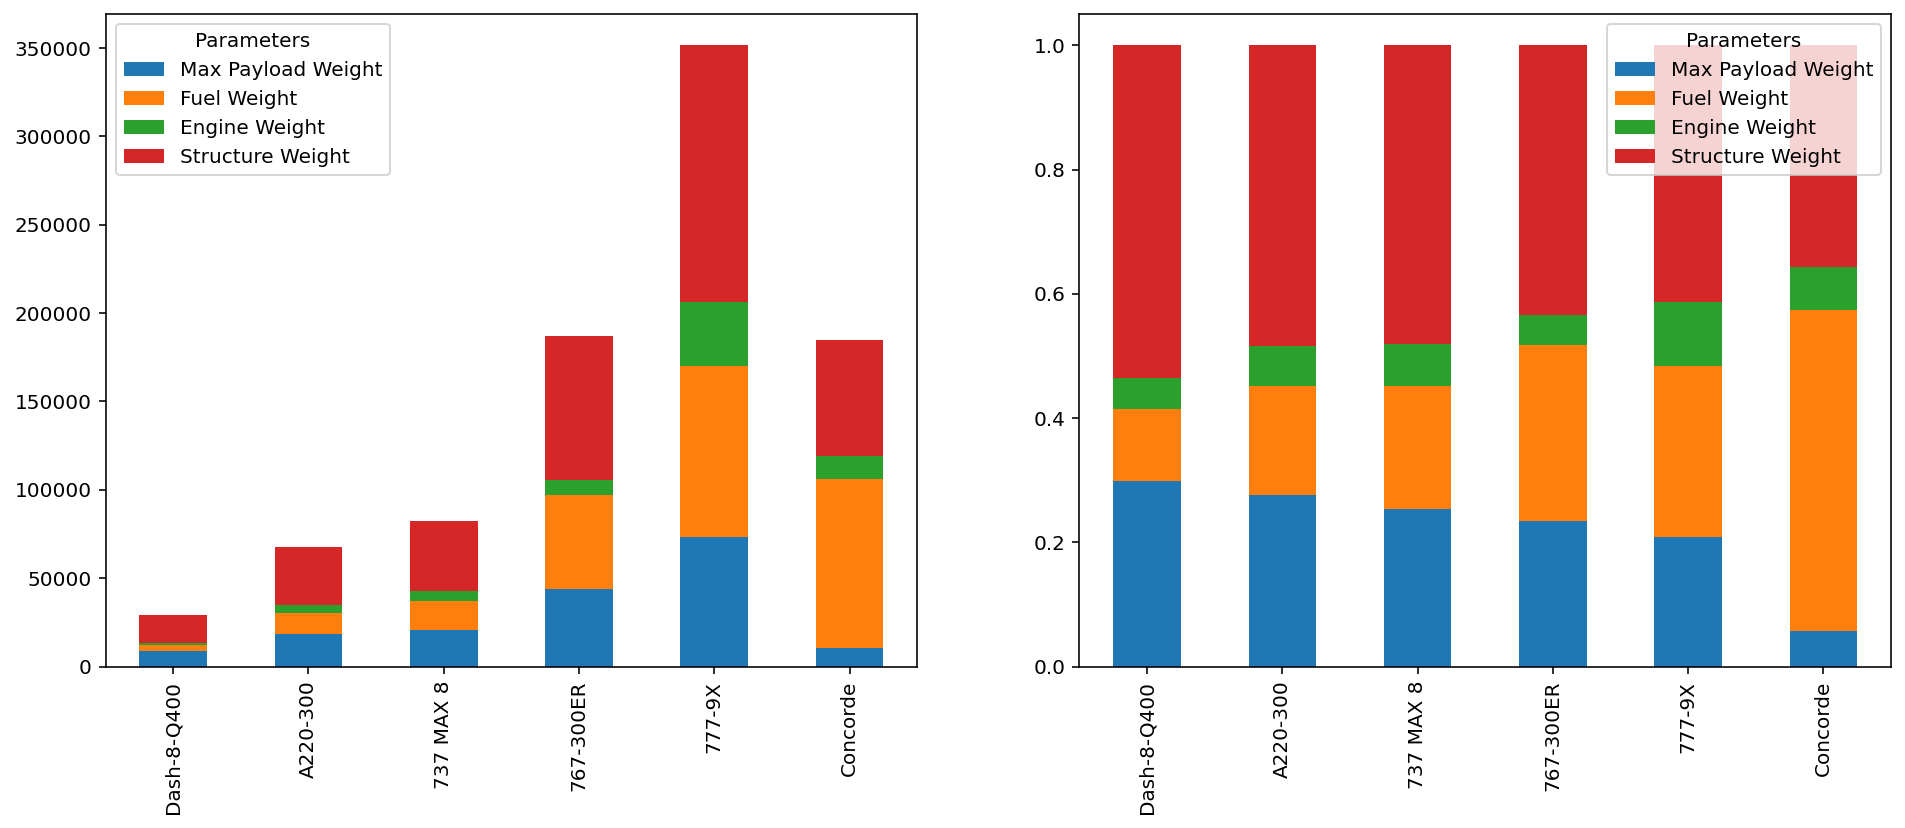

In [13]:
# Calculate the total propulsion system (i.e. engine) weight for the aircraft and append it to the aircraft dataframe
for aircraft in Aircraft:
  AircraftData.loc['Engine Weight', aircraft] = ( EngineData.loc['Weight', AircraftData.loc['Engine Type', aircraft]] * 
                                                 AircraftData.loc['Engine Number', aircraft] )

# Calculate the weight of the aircraft structure w/o the propulsion system
AircraftData.loc['Structure Weight'] = ( AircraftData.loc['Operating Empty Weight'] - 
                                         AircraftData.loc['Engine Weight'] )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Stacked bar chart with aircraft weight breakdown
WeightSummary = AircraftData.loc['Max Payload Weight':'Structure Weight']
WeightSummary.transpose().applymap(lambda x: x.magnitude).plot.bar(stacked=True, ax=axes[0])

# Normalized Weight Summary 
NormWeightSummary = AircraftData.loc['Max Payload Weight':'Structure Weight'] / AircraftData.loc['Max Take Off Weight']
NormWeightSummary.transpose().applymap(lambda x: x.magnitude).plot.bar(stacked=True, ax=axes[1])

## Propulsion System Performance
The thrust power produced by an aircraft propulsion system is given by

$$ P_{thrust} = TV_{flight}$$

$T$ is the thrust, and $V_{flight}$ is the aircraft flight velocity.

Primary propulsors considered in this analysis will be either ducted fans or propellers (i.e. unducted fans).  However, the secondary thrust contributions of turbofan and turboprop cores will also be considered.

### Propulsion System Efficiency
The energy efficiency of the primary propulsors is given by

$$\eta_{propulsor} = \frac{TV_{flight}}{P_{shaft}}$$

$P_{shaft}$ is the input mechanical shaft power required to spin the propulsor.

In this analysis, multiple energy storage options will be considered--including batteries and fuels.  Furthermore, multiple energy conversion approches will be investigated.  These approaches will include--
1.  single conversion devices that directly convert stored chemical energy (e.g. fuel) into shaft power and 
2.  dual chained conversion devices where one devices converts stored chemical energy (e.g. fuel, battery) into electric power and a second device (e.g. an electric motor) converts the electric power into shaft power.

In the single conversion device scenario, the shaft power produced by the device may be expressed as

$$P_{shaft} = \eta_{thermochemical}P_{chemical}$$

$\eta_{thermal}$ is the thermo-chemical conversion efficiency.  For example, if the conversion device is a gas turbine, $\eta_{thermochemical}$ is the thermal efficiency of the gas generator.  

In the dual conversion device scenario, the shaft power produced by the device chain may be expressed as 

$$P_{shaft} = \frac{P_{shaft}}{P_{electric}}  \frac{P_{electric}}{P_{chemical}}P_{chemical} = \eta_{motor}\eta_{electrochemical}P_{chemical}$$

The propulsor and chemical to shaft power conversion efficiencies may be combined to yield the two following expressions for the overall efficiency of the propulsion system.

For the single conversion device (i.e. chemical --> mechanical)  scenario--

$$\eta_{overall} = \frac{TV_{flight}}{P_{chemical}} = \eta_{propulsor}\eta_{themochemical}$$

For the dual conversion device (i.e. chemical --> electrical --> mechanical) scenario--

$$\eta_{overall} = \eta_{propulsor}\eta_{motor}\eta_{electrochemical}$$

### Propulsion System Mass
The overall mass of a propulsion system is given by the two following expressions.

For the single conversion device scenario--

$$M_{overall} = M_{propulsor} + M_{thermochemical}$$

For the dual conversion device scenario--

$$M_{overall} = M_{propulsor} + M_{motor} + M_{electrochemical}$$

The power specific mass of a propulsion system is given by the following two expressions.

For the single conversion device scenario--

\begin{align}
\frac{M_{overall}}{P_{thrust}} & = \frac{M_{propulsor}}{P_{thrust}} + \frac{M_{thermochemical}}{P_{shaft}}\frac{P_{shaft}}{P_{thrust}} \\
& = \mu_{propulsor}+\frac{\mu_{thermochemical}}{\eta_{propulsor}}
\end{align}

For the dual conversion device scenario--

\begin{align}
\frac{M_{overall}}{P_{thrust}} & = \mu_{propulsor}+ \frac{M_{motor}}{P_{shaft}} \frac{P_{shaft}}{P_{thrust}} + \frac{M_{electrochemical}}{P_{electric}} \frac{P_{electric}}{P_{thrust}} \\
& = \mu_{propulsor} + \frac{\mu_{motor}}{\eta_{propulsor}} + \frac{\mu_{electrochemical}}{\eta_{motor}\eta_{propulsor}} \\
& = \mu_{propulsor} + \frac{1}{\eta_{propulsor}}\left(\mu_{motor} + \frac{\mu_{electrochemical}}{\eta_{motor}}\right)
\end{align}


In [14]:
"""Copy propulsion system schematics from github site"""
!rm *.png
!wget https://raw.githubusercontent.com/davetew/Zero-Carbon-Aviation/master/Gas-Turbine.png
!wget https://raw.githubusercontent.com/davetew/Zero-Carbon-Aviation/master/Fuel-Cell.png
!ls
!pwd

rm: cannot remove '*.png': No such file or directory
--2021-08-01 01:14:16--  https://raw.githubusercontent.com/davetew/Zero-Carbon-Aviation/master/Gas-Turbine.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14286 (14K) [image/png]
Saving to: ‘Gas-Turbine.png’

Gas-Turbine.png     100%[===================>]  13.95K  --.-KB/s    in 0s      

2021-08-01 01:14:16 (62.3 MB/s) - ‘Gas-Turbine.png’ saved [14286/14286]

--2021-08-01 01:14:16--  https://raw.githubusercontent.com/davetew/Zero-Carbon-Aviation/master/Fuel-Cell.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request s

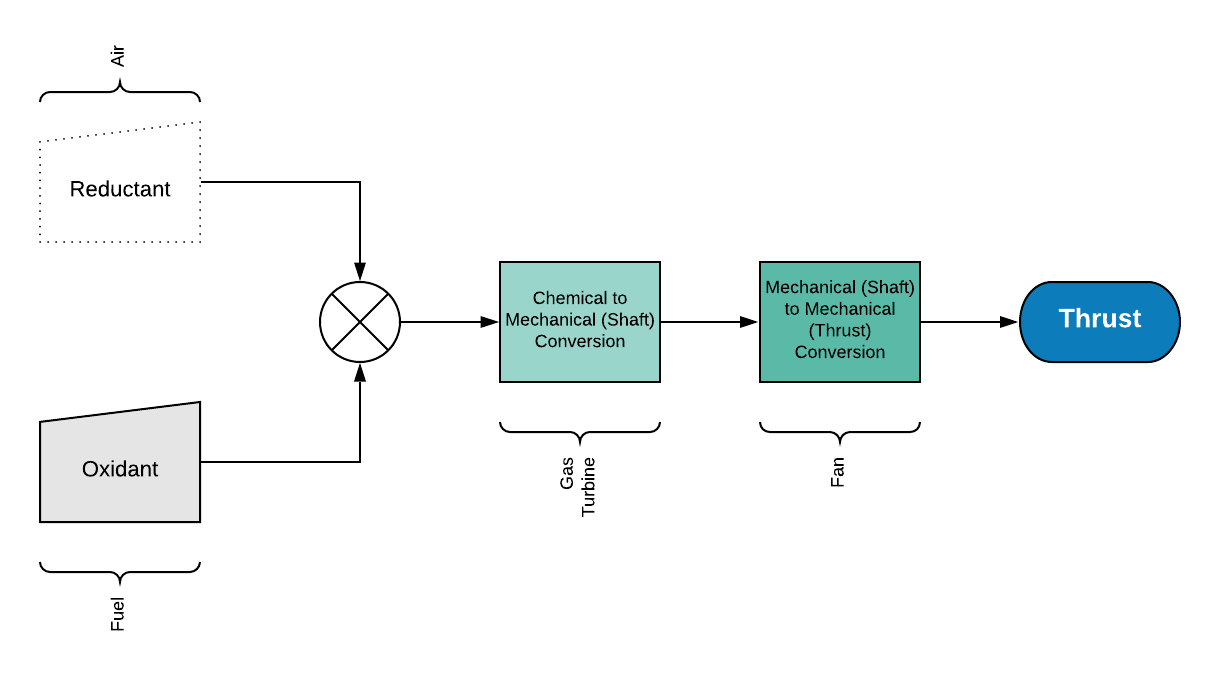

In [15]:
#@title Gas Turbine System Schematic - Single Conversion Device
Image('Gas-Turbine.png', width=800)

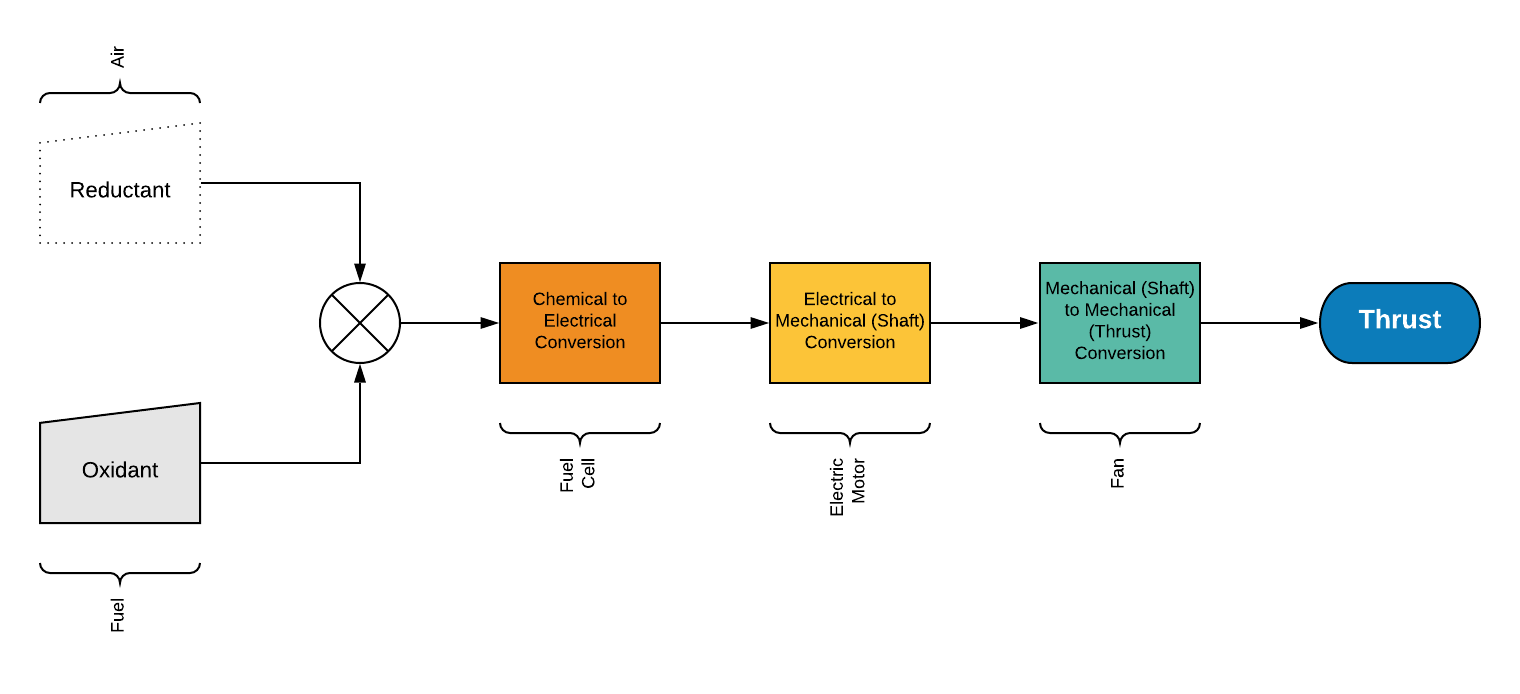

In [ ]:
#@title Fuel Cell Propulsion System Schematic - Dual Conversion Devices
Image('Fuel-Cell.png', width=800)

## Thrust Specific Fuel Consumption
The thrust specific fuel consumption (TSFC) of a thrust producing aircraft engine is given by

$$ TSFC = \frac{\dot{m}_{fuel}}{T} $$

$\dot{m}_{fuel}$ is the mass flow rate of fuel, and $T$ is the engine thrust.  Typical metric units for $TSFC$ are $g / kN s$.

The specific impulse of that same engine is given by

$$ I_{sp} = \frac{T}{\dot{m}_{fuel} g}  = \frac{1}{TSFC*g} $$

$g$ is the gravitional acceleration (e.g. $9.8  m/s^2$). The $I_{sp}$ is typically expressed in units of seconds.

For the above-specified units for $TSFC$, $I_{sp}$ in seconds may be calculated from the $TSFC$ per the below expression

$$ I_{sp} = \frac{1e6}{TSFC*g} $$

## Aircraft Range Model 
The range of an aircraft may be estimated from the Breguet range equation, which is derived below for aircraft that
1. lose mass via the consumption of fuel,
2. maintain a constant mass, and
3. aircraft that gain mass through the accumulation of oxygen in a metal air battery.

In each of these analyses, only the steady level portion of the flight will be considered.  In this portion of the flight,

\begin{align}
L & = W \\
T & = D
\end{align}

Hence, the required aircraft thrust may be expressed as a function of the weight and the aircraft lift to drag ratio.

$$ W = L = D\frac{L}{D} = T\frac{L}{D} $$

### Fuel-Consuming Aircraft
The rate of change of mass of a fuel-consuming aircraft during flight is given by

$$ -\frac{dW}{dt} = g\dot{m}_{f} = \frac{T}{I_{sp}}. $$

This expression may be inserted into the above differential equation for rate of change of aircraft mass during flight.

$$ \frac{dW}{dt} = -\frac{W}{(L/D)I_{sp}} $$ 

$$ \frac{dW}{W} = -\frac{dt}{(L/D)I_{sp}} $$

Both sides of the above expression may be integrated to yield and expression that relates the aircraft weight and flight duration.

$$ \ln\frac{W}{W_0} = - \frac{t}{(L/D)I_{sp}} $$

$$ t_{f} = \frac{L}{D}I_{sp}\ln\frac{W_0}{W_f} $$

Knowing the cruise/flight velocity ($V$), the range ($R$) may be calculated.

$$ R = t_{f}V = V \frac{L}{D}I_{sp}\ln\frac{W_0}{W_f} $$

$$ W_{f} = W_{0} - W_{fuel} $$

$$ R_{fc} = t_{f}V = V \frac{L}{D}I_{sp}\ln\frac{W_0}{W_{0} - W_{fuel}} $$

The above expression for the range of a fuel consuming aircraft may be rewritten in terms of the overall propulsion system efficiency ($\eta_{overall}$) and the specific energy of the energy storage media ($\epsilon_{fuel}$).

$$ R_{fc} = \ln \frac{1}{1-\frac{M_{fuel}}{M_{0}}}\frac{1}{g}\frac{L}{D}\eta_{overall}\epsilon_{fuel} $$

Reference: [MIT Unified Notes](http://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node98.html)

### Constant Mass Aircraft
The maximum duration of a flight of a constant mass aircraft is given by

$$t_{f} = \frac{E_{chemical}}{P_{chemical}}$$

$E_{chemical}$ is the total stored energy at the begining of the flight, and $P_{chemical}$ is the rate at which that energy is consumed during the flight.

Using the definition of the overall propulsion system efficiency, $t_{f}$ may be expressed as

$$t_{f} = \frac{E_{chemical}}{TV_{flight}}\eta_{overall}$$

The range is equal to the time of flight times the flight velocity--

$$R_{cm}=t_{f}V_{flight}$$

For steady level flight, the required thrust may be expressed in terms of the aircraft weight and lift to drag ratio.

$$T=D=\frac{W_{0}}{L/D}$$

In sum, the range may be expressed as a function of the initial stored chemical energy, the aircraft weight, the aircraft lift to drag ratio and the overall propulsion system efficiency.

$$R_{cm}=\frac{E_{chemical}}{W_{0}}\frac{L}{D}\eta_{overall}$$


The inital stored chemical energy ($E_{chemical}$) may be expressed in terms of the energy specific mass of the storage media and its mass.

\begin{align}
E_{chemical} & = M_{chemcal}\frac{E_{chemical}}{M_{chemical}} \\
& = M_{chemical} \epsilon_{chemical} 
\end{align}

$\epsilon_{chemical}$ is the mass-specific energy (e.g. $\frac{Wh}{kg}$) of the storage media.

Consequently, the range of a constant mass aircraft mass be expressed as

$$R_{cm}=\frac{M_{chemical}}{M_{0}}\frac{1}{g}\frac{L}{D}\eta_{overall}\epsilon_{chemical}$$

### Oxygen-Accumulating Aircraft
The rate of change of mass of an oxygen-accumulating aircraft during flight is given by 

$$ \frac{dW}{dt} = g\dot{m}_{O_{2}} = \frac{T}{I'_{sp}}. $$

$$ I'_{sp} = \frac{T}{\dot{m}_{O_{2}}} $$

In steady level flight,

$$ \frac{dW}{W} = \frac{dt}{(L/D)I'_{sp}} $$

Integrating both sides,

$$ \ln\frac{W}{W_0} = \frac{t}{(L/D)I'_{sp}} $$

$$ t_{f} = \frac{L}{D}I'_{sp}\ln\frac{W_f}{W_0} $$

$$ W_{f} = W_{0} + W_{oxygen} $$

$$ R_{oa} = t_{f}V = V \frac{L}{D}I'_{sp}\ln\frac{W_{0} + W_{oxygen}}{W_{0}} $$

The above expression for the range of an oxygen accumulating aircraft may be written in terms of the overall propulsion system efficiency ($\eta_{overall}$) and the mass specific energy ($\epsilon_{chemical}$) of the energy storage media.

$$ R_{oa} = \ln \left(1 + \frac{M_{ox}}{M_{0}} \right) \frac{1}{g} \frac{TV}{\dot{m}_{O_{2}}} $$

For a Lithium-Air battery,

$$ 2Li + O_{2} \rightarrow Li_{2}O_{2}$$

Hence,

\begin{align}
\frac{\dot{n}_{O_{2}}}{\dot{n}_{Li}} &= \frac{1}{2} \\
\frac{\dot{m}_{O_{2}}}{\dot{m}_{Li}} & = \frac{\dot{n}_{O_{2}}}{\dot{n}_{Li}} \frac{\bar{m}_{O_{2}}}{\bar{m}_{Li}} \\
& = \frac{1}{2} \frac{\bar{m}_{O_{2}}}{\bar{m}_{Li}} = \frac{1}{2} \frac{32}{7}
\end{align}

Thus,

$$ \dot{m}_{O_{2}} =\frac{1}{2} \frac{32}{7} \dot{m}_{Li} = 2.3 \dot{m}_{Li} \equiv \beta \dot{m}_{Li} $$

Hence, the range expression may be written as 

\begin{align}
R_{oa} & = \ln \left(1 + \frac{M_{ox}}{M_{0}} \right) \frac{1}{g} \frac{TV}{\beta\dot{m}_{Li}\epsilon_{chemical}} \epsilon_{chemical} \\
& = \ln \left (1 + \frac{M_{ox}}{M_{0}} \right)\frac{1}{g}\frac{L}{D}\eta_{overall}\frac{\epsilon_{chemical}}{\beta}
\end{align}

$\epsilon_{chemical}$ is the lower heating value of the fuel.

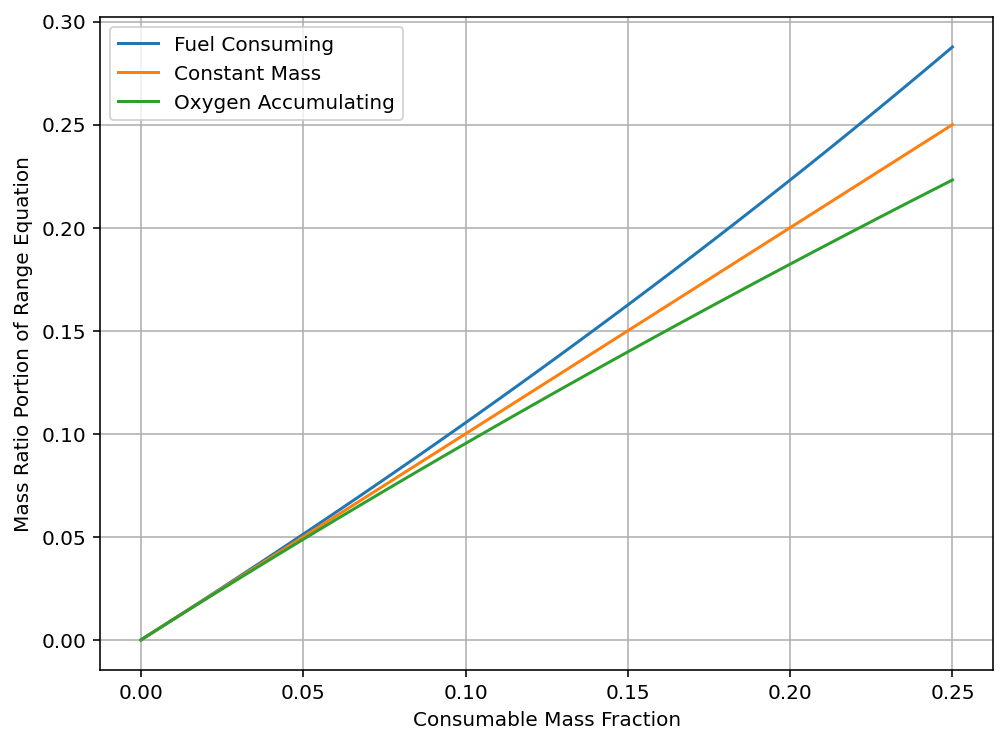

In [16]:
"""Compare the ranges of the three types of aircraft: fuel consuming, constant mass & oxygen accumulating as function of the stored chemical to
aircraft mass ratio."""

μ_stored = np.linspace(0,0.25,100)

# Range
R_fc = lambda μ: -np.log(1-μ)
R_cm = lambda μ: μ
R_oa = lambda μ: np.log(1+μ)

plt.figure(figsize=(8,6))
plt.plot(μ_stored,[R_fc(μ_s) for μ_s in μ_stored], label='Fuel Consuming')
plt.plot(μ_stored,[R_cm(μ_s) for μ_s in μ_stored], label='Constant Mass')
plt.plot(μ_stored,[R_oa(μ_s) for μ_s in μ_stored], label='Oxygen Accumulating')
plt.xlabel('Consumable Mass Fraction')
plt.ylabel('Mass Ratio Portion of Range Equation')
plt.legend()
plt.grid()
plt.show()

In [17]:
class Aircraft:
    """Aircraft class for data storage and estimation of flight performance characteristics.
    The inputs required for initialization include 
      1. the aircraft type as string,
      2. aircraft performance data as a pandas dataframe,
      3. engine performance data as a pandas dataframe, and
      4. the nominal fuel type specification (e.g. JetA())
      
    The type specified must be a column name in the aircraft dataframe.  The aircraft and engine
    dataframes must have the structure specified earlier in this notebook."""
    
    # Gravitational acceleration
    _g = Q_( constants.g, ureg['m/s**2'])
    
    def __init__(self,Type, AircraftData=AircraftData, EngineData=EngineData, Fuel=JetA()):
        """Initialize the class by extracting performance data of interest for the aircraft specified by
        Type from AircraftData"""
        
        if Type not in AircraftData.columns:
            raise TypeError(f"Invalid aircraft type valid types include: {AircraftData.columns}")
        
        # Save the name
        self.Type = Type
        
        # Save the aircraft performance data for the specified aircraft
        self.Aircraft = AircraftData[Type]
        
        # Save the engine performance data for the specified engine
        self.Engines = EngineData[AircraftData[Type]['Engine Type']]
        
        # Save the fuel class specification
        self.Fuel = Fuel
    
    @property
    def OverallEfficiency(self):
        return ( self.Aircraft['Cruise Speed']/self.Engines['TSFC']/ 
                self.Fuel.lower_heating_value ).to(ureg[''])
    
    @property
    def Isp(self):
        """Calculate the specific impulse in seconds"""
        return (1 / self.Engines['TSFC'] / self._g ).to(ureg['s'])
      
    @property
    def FinalWeight(self):
        """Calculate the final aircraft weight"""
        return self.Aircraft['Max Take Off Weight'] - self.Aircraft['Fuel Weight']
    
    @property
    def Lift2Drag(self):
        """Estimate the aircraft lift to drag ratio from the available range 
        & weight performance data"""
        return ( self.Aircraft['Range'] / self.Aircraft['Cruise Speed'] / self.Isp / 
                np.log(self.Aircraft['Max Take Off Weight']/ self.FinalWeight) ).to(ureg[''])
    
    @property
    def CruiseThrust(self):
        """Return the cruise thrust in kN"""
        return (( self.Aircraft['Max Take Off Weight'] - self.Aircraft['Fuel Weight']/2 ) *
                 self._g / self.Lift2Drag ).to(ureg['kN'])
      
    @property
    def CruiseFuelBurn(self):
      """Return the cruise fuel consumption in kg/hr"""
      return ( self.CruiseThrust * self.Engines['TSFC'] ).to(ureg['kg/hr'])
      
    @property
    def CruiseThrustPower(self):
      """Return the cruise thust power in MW"""
      return ( self.CruiseThrust * self.Aircraft['Cruise Speed'] ).to(ureg['MW'])
    
    @property
    def SpecificPower(self):
      "Return the propulsion system specific power in W/kg"
      return ( self.CruiseThrustPower / self.Aircraft['Engine Number'] / 
               self.Engines['Weight'] ).to(ureg['W/kg'])
    
    @property
    def CruiseCO2Emissions(self):
      """Calculate the passenger-specific cruise CO2 emissions (kg CO2 / km / passenger)"""
      return ( self.CruiseFuelBurn * self.Fuel.emissions_factor * 
               self.Fuel.lower_heating_value / self.Aircraft['Cruise Speed'] / 
               self.Aircraft['Max Seats'] / ureg['passenger']).to('kg/km/passenger')
    
    @property
    def CruiseEnergyConsumption(self):
      """Calculate the passenger-specific cruise energy consumption (kWh / km / passenger)"""
      return ( self.CruiseFuelBurn *  
         self.Fuel.lower_heating_value / self.Aircraft['Cruise Speed'] / 
         self.Aircraft['Max Seats'] / ureg['passenger'] ).to('kWh/km/passenger')
      
    @property 
    def FinalWeightEstimate(self):
        """Estimate the final weight given the lift to drag ratio """
        return np.nan
   
  
    def _drawFuelLines(self, η_overall):
      """Draw fuel heating value lines on payload or range contour charts.
          Assumed x -- Lower Heating Value (Wh/kg)
          """
   
      #Fuels = [Ammonia(), Ethanol(), JetA(), Hydrogen(stored_mass_fraction=1.0)]
      Fuels = [Ammonia(), Ethanol(), JetA()]
      linestyles = ['-.', '--', ':', '-']
      colors = ['y','orange','w','r']
      
      for fuel, linestyle, color in zip(Fuels, linestyles, colors):
        plt.plot(fuel.stored_lower_heating_value.to('kWh/kg')*np.ones(2), 
                 [np.min(η_overall),np.max(η_overall)], 
                linestyle=linestyle, linewidth=2.0, color=color)
        plt.text(fuel.stored_lower_heating_value.to('kWh/kg').magnitude-1.5, 
                 np.min(η_overall)+0.02,
                 fuel.name, rotation=90, color=color, 
                 verticalalignment='bottom', fontsize=18)
        
    def RangeContourChart(self, 
                          η_overall = np.linspace(0.1,0.8,20), 
                          ϵ_fuel = Q_( np.linspace(.150,35,21), ureg['kWh/kg']),
                          range_units='km'):
        """Draw range contours as functions of the overall propulsion system efficiency
        and the specific energy of the storage media"""
    
        Range = lambda η_o, ϵ_f: ( np.log( self.Aircraft['Max Take Off Weight'] /
                                           self.FinalWeight ) / self._g *
                                           self.Lift2Drag * η_o * ϵ_f ).to(ureg[range_units])
      
        #Range2DArray = np.array([[Range(η, ϵ).magnitude for ϵ in ϵ_fuel] for η in η_overall])
        Range2DArray = np.array([[ (Range(η, ϵ) / self.Aircraft['Range']).to('') for ϵ in ϵ_fuel] for η in η_overall])

        plt.figure(figsize=(10,8))
        plt.contourf(ϵ_fuel.magnitude, η_overall, Range2DArray, 20)
        plt.colorbar()
        cs=plt.contour(ϵ_fuel.magnitude, η_overall, Range2DArray, 
                    #levels=[self.Aircraft['Range'].to(ureg(range_units)).magnitude], colors=['w'])
                    levels=[0.5, 0.75, 1], colors=['w'], linestyles=[':','--','-'])
        plt.clabel(cs)
        plt.xlabel('Specific Energy of Storage Media (Wh/kg)', fontsize=18)
        plt.ylabel('Overall Propulsion System Efficiency', fontsize=18)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
        plt.title(self.Type + ':  Range / Current Range Contours', fontsize=18)
        
        # Plot current fuel & efficiency point
        plt.plot(self.Fuel.lower_heating_value.to('kWh/kg'), self.OverallEfficiency, marker='o', markeredgecolor='w', 
         markerfacecolor='w', markersize=14)
        
        # Plot fuel lines
        self._drawFuelLines(η_overall)
        
        plt.show()
        


    def PayloadContourChart(self, CustomRange=None,
                            η_overall = np.linspace(0.1,0.8,50), 
                            ϵ_fuel = Q_( np.linspace(.150,35,100), ureg['kWh/kg']),
                            payload_units='kg'):
      """Draw payload contours as functions of the overall propulsion system efficiency
      and the specific energy of the storage media at constant range"""
      
      # Use the default aircraft range unless specified
      Range = self.Aircraft['Range'] if CustomRange is None else CustomRange
      
      # Initial to final aircraft weight ratio
      ϕ = lambda η_o, ϵ_f: np.exp( Range * self._g / self.Lift2Drag / 
                                   η_o / ϵ_f ).to(ureg[''])
      
      # Payload weight
      PayloadWeight = lambda η_o, ϵ_f: ( self.Aircraft['Max Take Off Weight'] /
                                         ϕ(η_o, ϵ_f) - 
                                         self.Aircraft['Operating Empty Weight'] ).to(ureg[payload_units])   


      #PLW_2DArray = np.array([[(PayloadWeight(η, ϵ) 
      #                          if PayloadWeight(η, ϵ) > 0 else 0*ureg[payload_units]).magnitude 
      #                          for ϵ in ϵ_fuel] for η in η_overall])
      
      PLW_2DArray = np.array([[(PayloadWeight(η, ϵ) / self.Aircraft['Max Payload Weight']
                                if PayloadWeight(η, ϵ) > 0 else 0*ureg[payload_units]).magnitude 
                                for ϵ in ϵ_fuel] for η in η_overall])
      
      
      plt.figure(figsize=(10,8))
      plt.contourf(ϵ_fuel.magnitude, η_overall, PLW_2DArray, 20)
      plt.colorbar()
      plt.xlabel('Specific Energy of Storage Media (kWh/kg)', fontsize=18)
      plt.contour(ϵ_fuel.magnitude, η_overall, PLW_2DArray, 
                  #levels=[self.Aircraft['Max Payload Weight'].to(ureg[payload_units]).magnitude], colors=['w'])
                  levels=[1], colors=['w'])
      plt.ylabel('Overall Propulsion System Efficiency', fontsize=18)
      plt.xticks(fontsize=14); plt.yticks(fontsize=14)
      plt.title(self.Type + ':  Payload / Current Payload Contours', fontsize=18)
      
      # Plot current fuel & efficiency point
      plt.plot(self.Fuel.lower_heating_value.to('kWh/kg'), self.OverallEfficiency, marker='o', markeredgecolor='w', 
         markerfacecolor='w', markersize=14)
      
      # Plot fuel lines
      self._drawFuelLines(η_overall)
   
      plt.show()
  
    def PayloadTechnologyContour(self, CustomRange=None, Fuel=JetA(),
                                 η_overall = np.linspace(0.2,0.8,50), 
                                 Spec_Pow = Q_( np.linspace(100,5000), ureg['W/kg']),
                                 payload_units='kg'):
      """Draw payload contours as functions of the propulsion system overall efficiency
      and specific power"""
      
      # Use the default aircraft range unless specified
      Range = self.Aircraft['Range'] if CustomRange is None else CustomRange
      
      # Initial to final aircraft weight ratio
      ϕ = lambda η_o : np.exp( Range * self._g / self.Lift2Drag / 
                               η_o / Fuel.lower_heating_value ).to(ureg[''])

      # Propulsion System Weight as a function of the specific power
      PropulsionWeight = lambda σ: ( self.CruiseThrustPower / σ ).to('kg')
      
      # Updated Empty Weight as a function of the propulsion system specific power (σ) 
      OEW = lambda σ: (self.Aircraft['Operating Empty Weight'] - 
                       self.Engines['Weight'] * self.Aircraft['Engine Number'] 
                       + PropulsionWeight(σ)).to(ureg(payload_units))
      
      # Payload Weight as a function of the propulsion system overall efficiency and the specific power
      PayloadWeight = lambda η_o, σ: ( self.Aircraft['Max Take Off Weight'] /
                                       ϕ(η_o) - OEW(σ) ).to(ureg[payload_units])   


      PLW_2DArray = np.array([[(PayloadWeight(η, σ) / self.Aircraft['Max Payload Weight']
                          if PayloadWeight(η, σ) > 0 else 0*ureg[payload_units]).magnitude 
                          for σ in Spec_Pow] for η in η_overall])
      
      plt.figure(figsize=(10,8))
      plt.contourf(Spec_Pow.magnitude, η_overall, PLW_2DArray, 20)
      plt.colorbar()
      plt.xlabel('Cruise Specific Power of Propulsion System (W/kg)', fontsize=18)
      plt.contour(Spec_Pow.magnitude, η_overall, PLW_2DArray, 
                  levels=[1], colors=['w'])
      plt.ylabel('Overall Propulsion System Efficiency', fontsize=18)
      plt.xticks(fontsize=14); plt.yticks(fontsize=14)
      plt.title(self.Type + ':  Payload / Current Payload Contours, Fuel = ' + str(Fuel.name), fontsize=18)
      
      # Plot current fuel and efficiency point
      plt.plot(self.SpecificPower, self.OverallEfficiency, marker='o', markeredgecolor='w', 
         markerfacecolor='w', markersize=14)
      
      plt.show()     
      
    def RangeTechnologyContour(self, CustomPayload=None, Fuel=JetA(),
                                 η_overall = np.linspace(0.2,0.8,50), 
                                 Spec_Pow = Q_( np.linspace(100,5000), ureg['W/kg']),
                                 range_units='km'):
      """Draw range as functions of the propulsion system overall efficiency
      and specific power"""
      
      if CustomPayload is None:
        # Use nominal payload
        Payload = self.FinalWeight - self.Aircraft['Operating Empty Weight']

      # Propulsion System Weight as a function of the specific power
      PropulsionWeight = lambda σ: ( self.CruiseThrustPower / σ ).to('kg')
      
      # Updated Empty Weight as a function of the propulsion system specific power (σ) 
      OEW = lambda σ: (self.Aircraft['Operating Empty Weight'] - 
                       self.Engines['Weight'] * self.Aircraft['Engine Number'] 
                       + PropulsionWeight(σ) )

      # Final aircraft weight
      FinalWeight = lambda σ: OEW(σ) + Payload
      
      # Initial to final aircraft weight ratio
      ϕ = lambda σ: np.max( (self.Aircraft['Max Take Off Weight'] / FinalWeight(σ), 1) )

      # Aircraft range
      Range = lambda η_o, σ: ( np.log( ϕ(σ) ) / self._g *
                                   self.Lift2Drag * η_o * Fuel.lower_heating_value ).to(range_units)
      
      Range2DArray = np.array([[ (Range(η, σ) / self.Aircraft['Range']).to('') for σ in Spec_Pow] for η in η_overall])
                    
      plt.figure(figsize=(10,8))
      plt.contourf(Spec_Pow.magnitude, η_overall, Range2DArray, 20)
      plt.colorbar()
      plt.xlabel('Cruise Specific Power of Propulsion System (W/kg)', fontsize=18)
      cs=plt.contour(Spec_Pow.magnitude, η_overall, Range2DArray, 
                  levels=[0.5,0.75,1], colors=['w'], linestyles=[':','--','-'])
      plt.clabel(cs)
      plt.ylabel('Overall Propulsion System Efficiency', fontsize=18)
      plt.xticks(fontsize=14); plt.yticks(fontsize=14)
      plt.title(self.Type + ':  Range / Current Range Contours, Fuel = ' + str(Fuel.name), fontsize=18)
      
      # Plot current fuel and efficiency point
      plt.plot(self.SpecificPower, self.OverallEfficiency, marker='o', markeredgecolor='w', 
         markerfacecolor='w', markersize=14)
      
      plt.show()
      
    def MultiFuelPayloadTechContour(self, CustomRange=None, Fuels= [Ammonia(), Ethanol(), JetA(), Hydrogen()],
                                 η_overall = np.linspace(0.2,0.8,50), 
                                 Spec_Pow = Q_( np.linspace(100,5000,100), ureg['W/kg']),
                                 payload_units='kg'):
      
      linestyles = ['-.', '--', ':', '-']
      colors = ['y','orange','k','r']

      contour_coords = {}
      plt.figure(figsize=(10,8))
      
      for fuel, linestyle, color in zip(Fuels, linestyles, colors):
  
        # Use the default aircraft range unless specified
        Range = self.Aircraft['Range'] if CustomRange is None else CustomRange

        # Initial to final aircraft weight ratio
        ϕ = lambda η_o : np.exp( Range * self._g / self.Lift2Drag / 
                                 η_o / fuel.stored_lower_heating_value ).to(ureg[''])

        # Propulsion System Weight as a function of the specific power
        PropulsionWeight = lambda σ: ( self.CruiseThrustPower / σ ).to('kg')

        # Updated Empty Weight as a function of the propulsion system specific power (σ) 
        OEW = lambda σ: (self.Aircraft['Operating Empty Weight'] - 
                         self.Engines['Weight'] * self.Aircraft['Engine Number'] 
                         + PropulsionWeight(σ)).to(ureg(payload_units))

        # Payload Weight as a function of the propulsion system overall efficiency and the specific power
        PayloadWeight = lambda η_o, σ: ( self.Aircraft['Max Take Off Weight'] /
                                         ϕ(η_o) - OEW(σ) ).to(ureg[payload_units])   


        PLW_2DArray = np.array([[(PayloadWeight(η, σ) / self.Aircraft['Max Payload Weight']
                            if PayloadWeight(η, σ) > 0 else 0*ureg[payload_units]).magnitude 
                            for σ in Spec_Pow] for η in η_overall])

        cs = plt.contour(Spec_Pow.magnitude, η_overall, PLW_2DArray, 
                        levels=[1], colors=[color])
        
        contour_coords[fuel.name] = cs.allsegs[0][0]
        
        plt.text(contour_coords[fuel.name][0,0],contour_coords[fuel.name][0,1],
                 fuel.name, rotation=90, verticalalignment='top', 
                 fontsize=18, color=color)
        
        plt.xlabel('Cruise Specific Power of Propulsion System (W/kg)', fontsize=18)
        plt.ylabel('Overall Propulsion System Efficiency', fontsize=18)
        
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
      
      # Plot current fuel and efficiency point
      plt.plot(self.SpecificPower, self.OverallEfficiency, marker='o', markeredgecolor='k', 
         markerfacecolor='k', markersize=14)
      plt.grid(True)
      
      plt.title(self.Type + ':  Nominal Payload Contour for Various Fuels', fontsize=18)


      plt.show()
      
      return contour_coords
      
    def Summary(self):
      """Return & display an aircraft Performance Summary"""
      Summary = pd.DataFrame.from_dict({self.Type: {'η_overall': self.OverallEfficiency,
                                                   'I_sp': self.Isp,
                                                   'L/D': self.Lift2Drag,
                                                   'Cruise / Max SL Thrust': self.CruiseThrust/self.Engines['Thrust Take Off']/self.Aircraft['Engine Number'], 
                                                   'Cruise Thrust Power': self.CruiseThrustPower,
                                                   'Cruise CO2 Emissions': self.CruiseCO2Emissions,
                                                   'Cruise Energy Consumption': self.CruiseEnergyConsumption}})
      display(Summary)
      return Summary
      


In [18]:
AC = Aircraft('737 MAX 8')
AC.Summary();

,737 MAX 8
Cruise / Max SL Thrust,0.1430636785634713 dimensionless
Cruise CO2 Emissions,0.03729997104796794 kilogram / kilometer / pas...
Cruise Energy Consumption,0.1423057230709384 kilowatt_hour / kilometer /...
Cruise Thrust Power,8.69620438650381 megawatt
I_sp,6578.814277276956 second
L/D,19.467112414052462 dimensionless
η_overall,0.3468375553651732 dimensionless


In [ ]:
Concorde = Aircraft('Concorde')
Concorde.Summary();

,Concorde
Cruise / Max SL Thrust,0.3621351420009456 dimensionless
Cruise CO2 Emissions,0.34094698725965655 kilogram / kilometer / pas...
Cruise Energy Consumption,1.300746922912085 kilowatt_hour / kilometer / ...
Cruise Thrust Power,146.8515942436554 megawatt
I_sp,3016.9118727157643 second
L/D,5.490679052087212 dimensionless
η_overall,0.40890812843371066 dimensionless


In [ ]:
TwinAisle = Aircraft('767-300ER')
TwinAisle.Summary();

,767-300ER
Cruise / Max SL Thrust,0.2302918372743297 dimensionless
Cruise CO2 Emissions,0.0435114414758627 kilogram / kilometer / pass...
Cruise Energy Consumption,0.16600050953990264 kilowatt_hour / kilometer ...
Cruise Thrust Power,29.97120322215804 megawatt
I_sp,11330.180144199203 second
L/D,12.387633391192717 dimensionless
η_overall,0.605157911188405 dimensionless


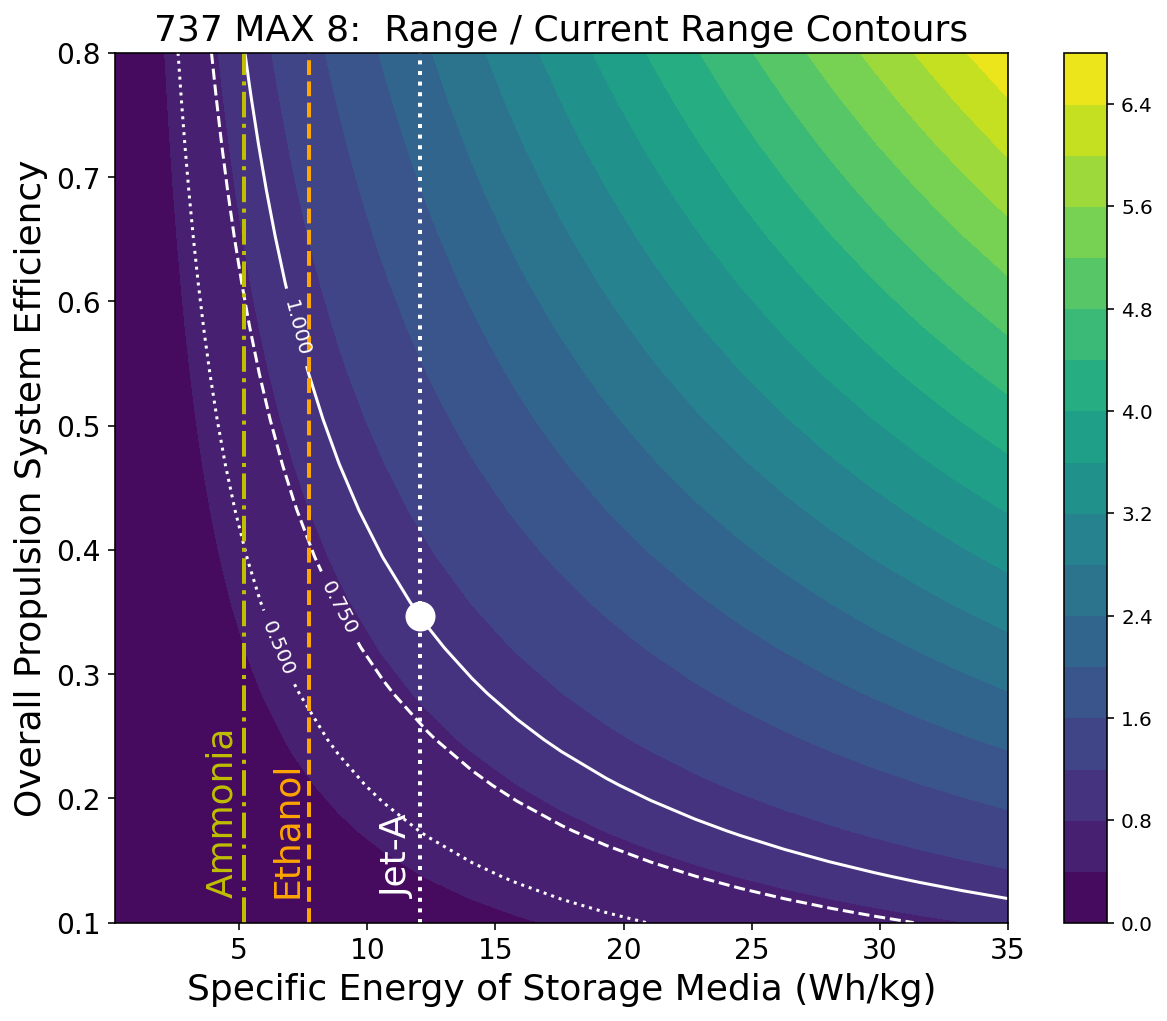

In [ ]:
AC.RangeContourChart()
#AC.RangeContourChart(Fuels= [Ammonia(), Ethanol(), JetA(), Hydrogen(stored_mass_fraction=0.1)])

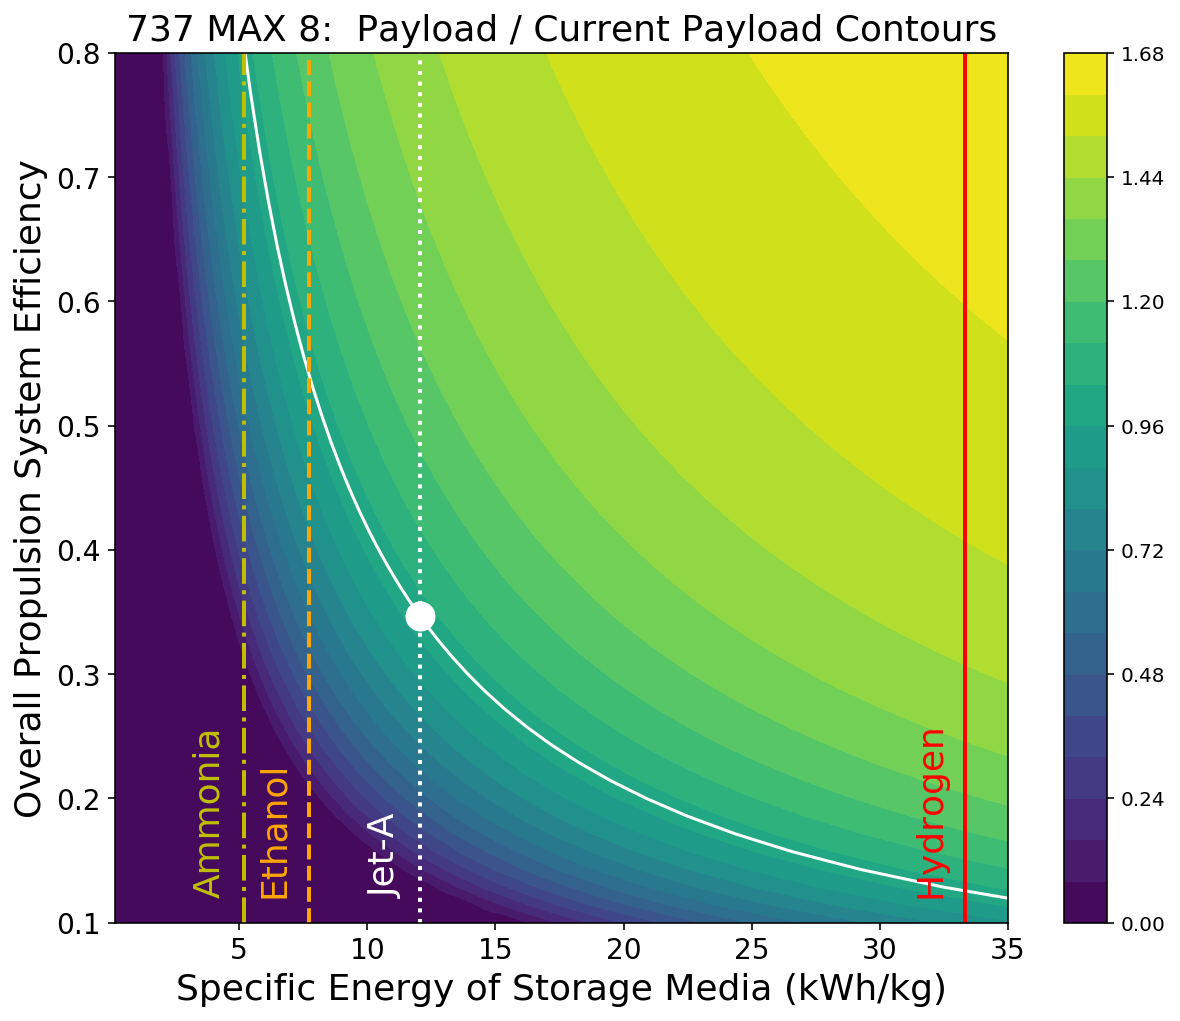

In [ ]:
AC.PayloadContourChart(CustomRange=None)

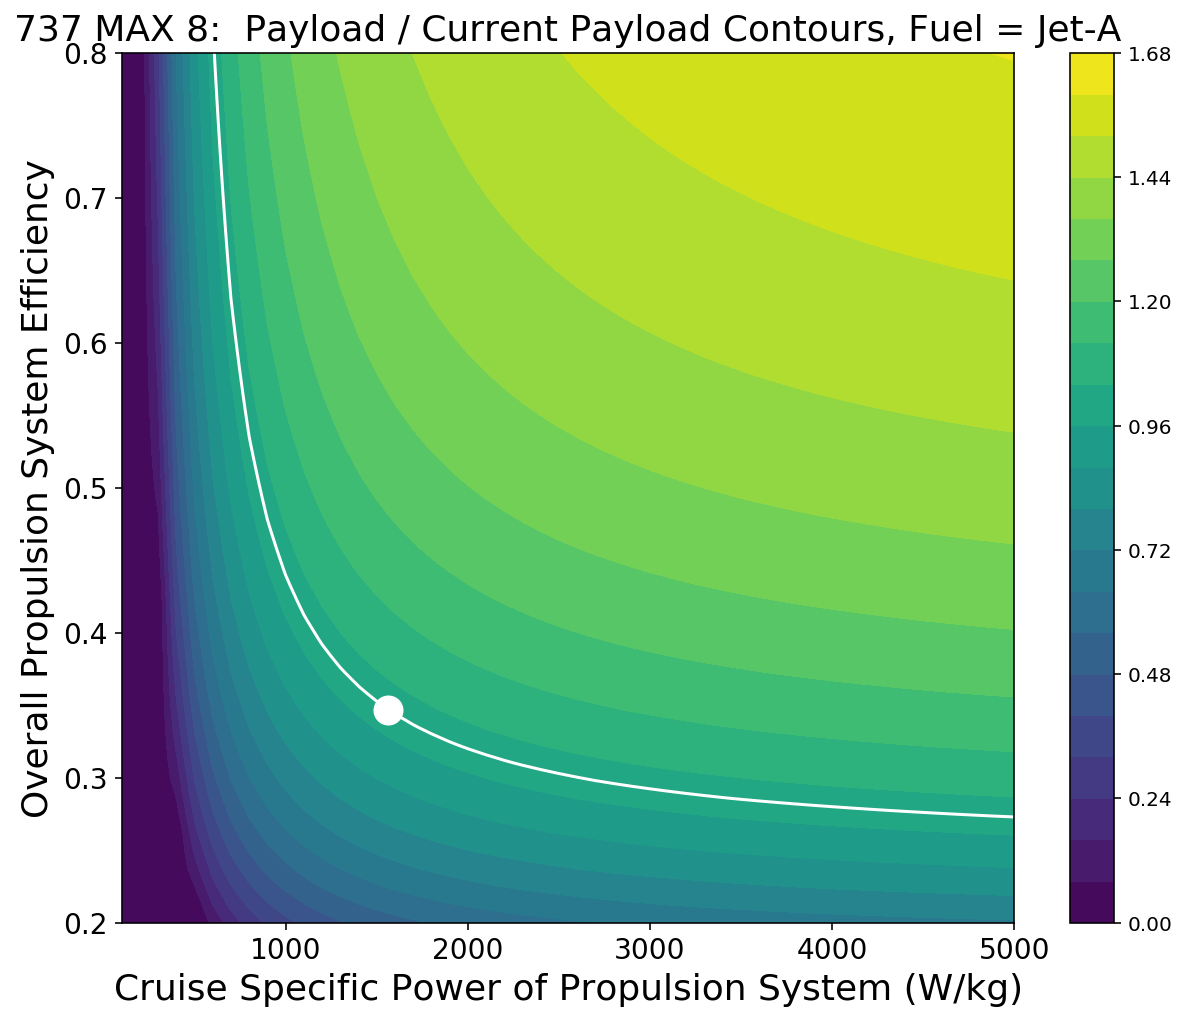

In [ ]:
AC.PayloadTechnologyContour()

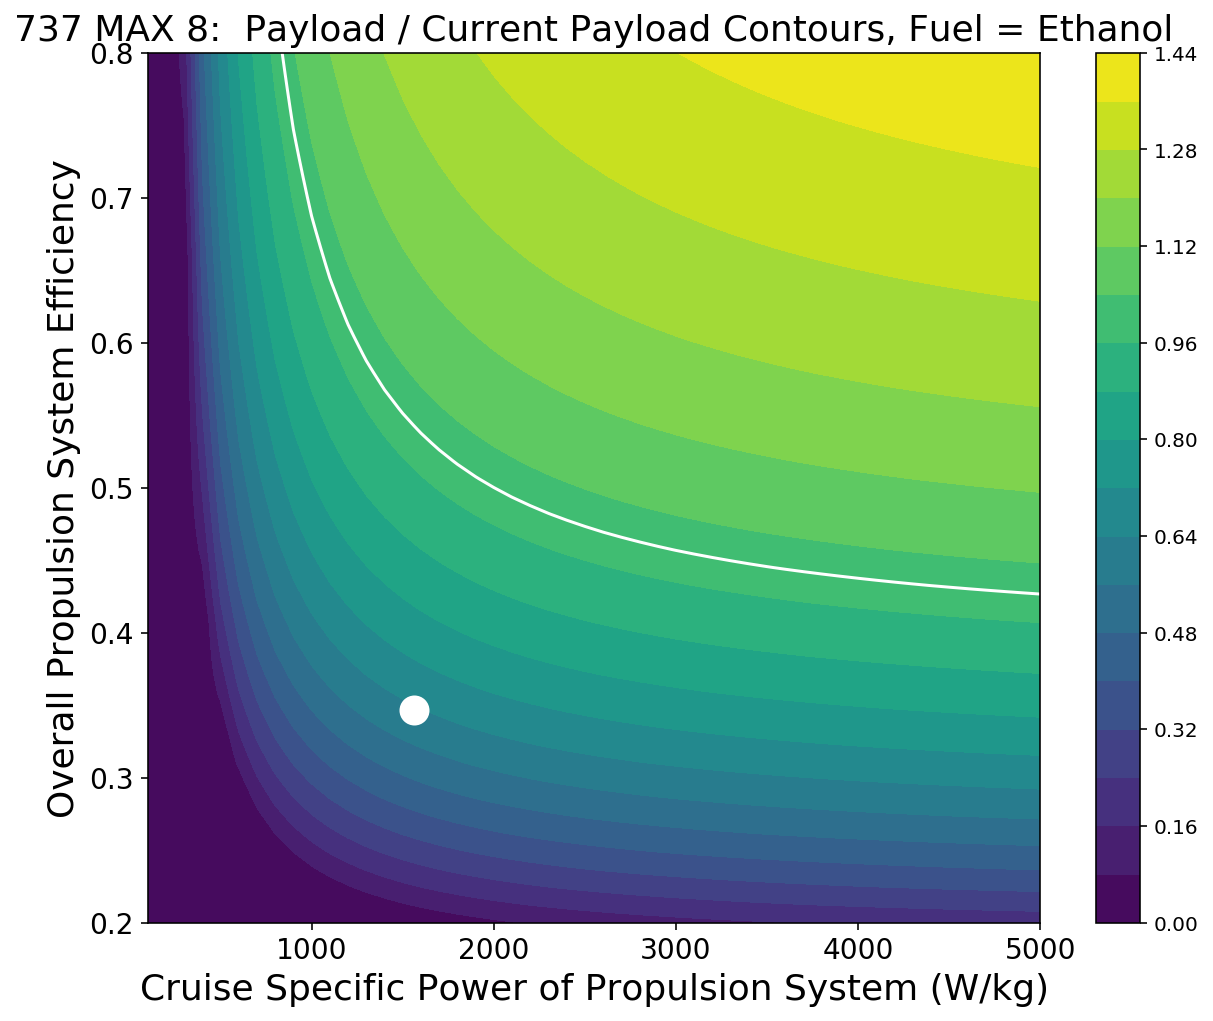

In [ ]:
AC.PayloadTechnologyContour(Fuel=Ethanol())

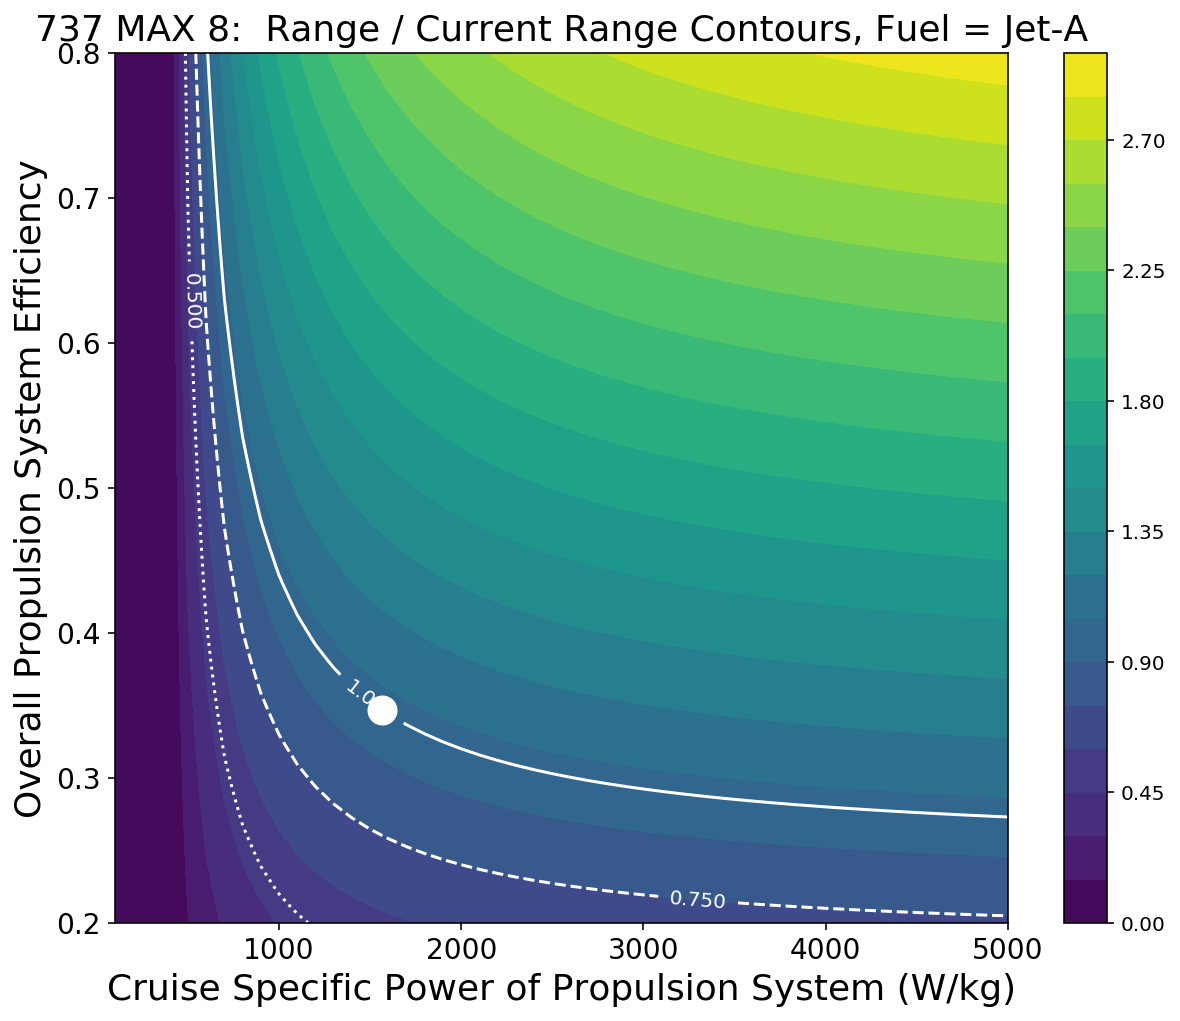

In [ ]:
AC.RangeTechnologyContour(Fuel=JetA())

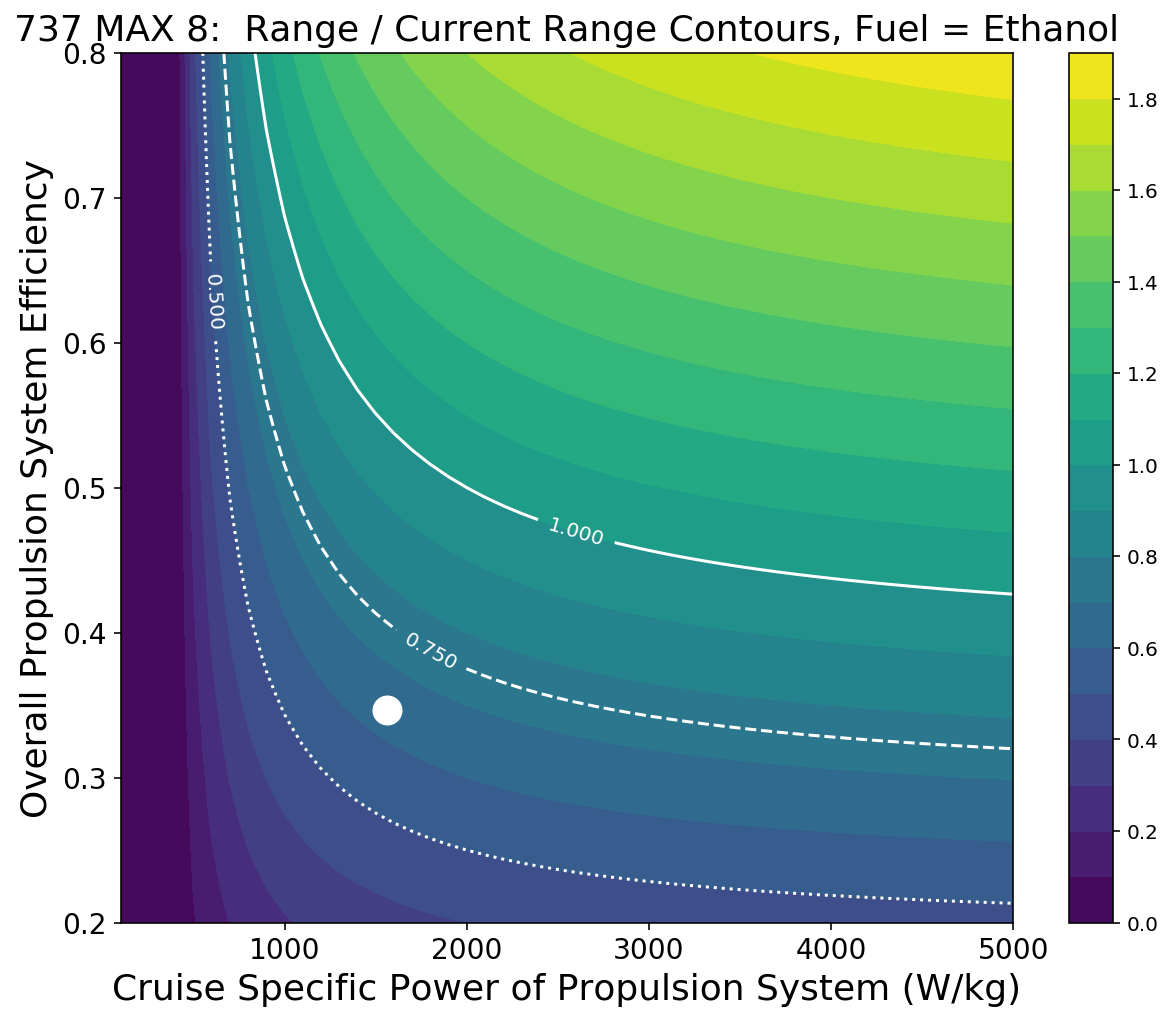

In [ ]:
AC.RangeTechnologyContour(Fuel=Ethanol())

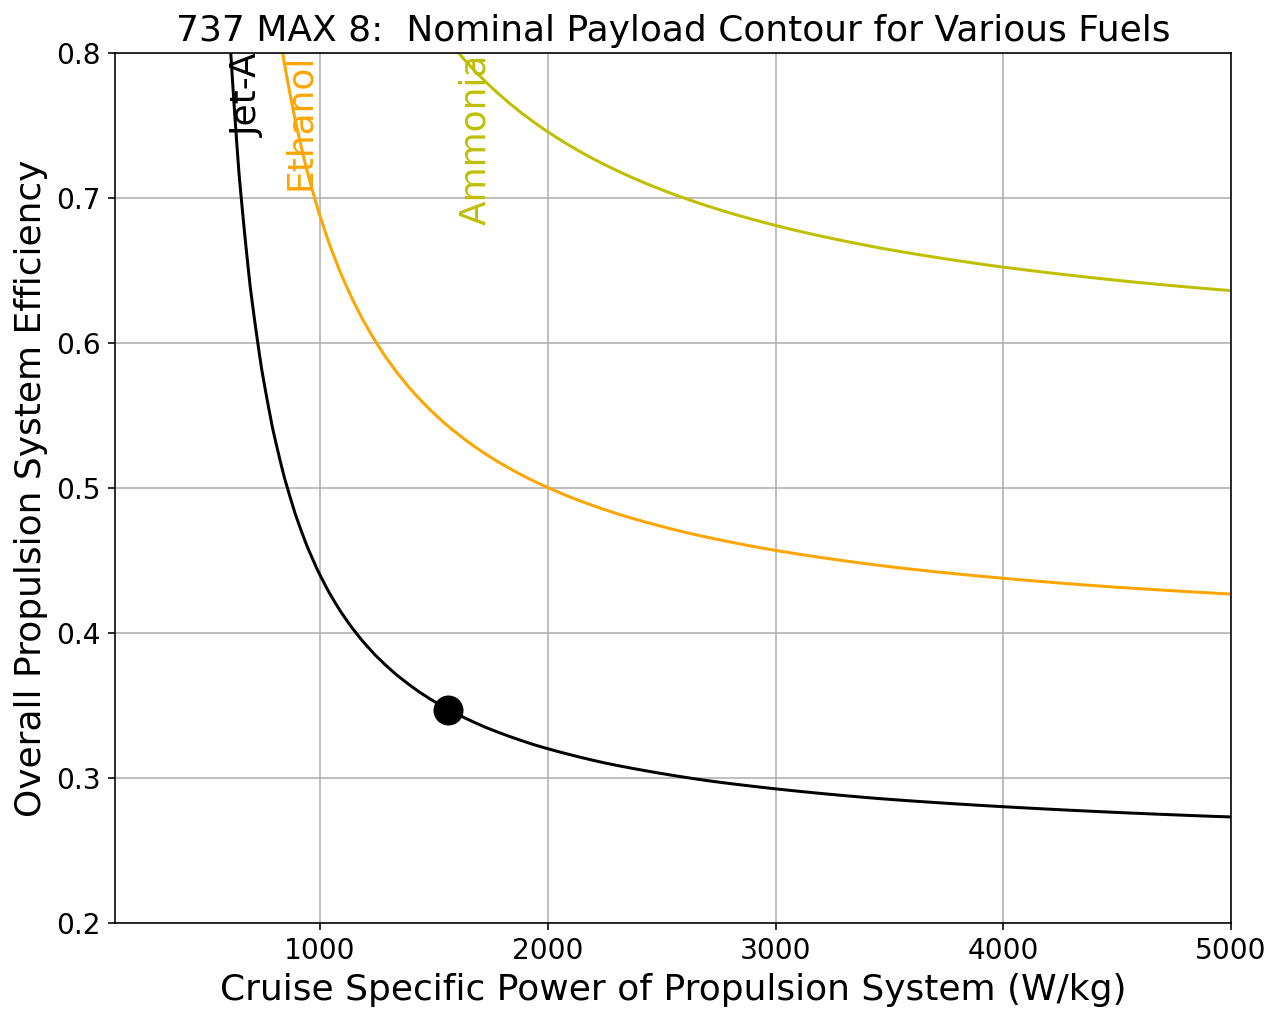

In [ ]:
FuelTechCon = AC.MultiFuelPayloadTechContour(Fuels= [Ammonia(), Ethanol(), JetA()]);

## Effective Radiative Forcing
When emitted from aircraft flying at altitude, both $CO_2$ and $H_2O$ have global warming implications.  Contrail formation associated with the emission and subsequent condensation of water vapor under the right conditions at high altitude may have a radiative forcing impact that exceeds that of carbon dioxide.

$$C_{n}H_{2n+2} + \frac{3n+1}{2}O_2 \rightarrow nCO_2 + \left( n+1 \right) H_2O$$


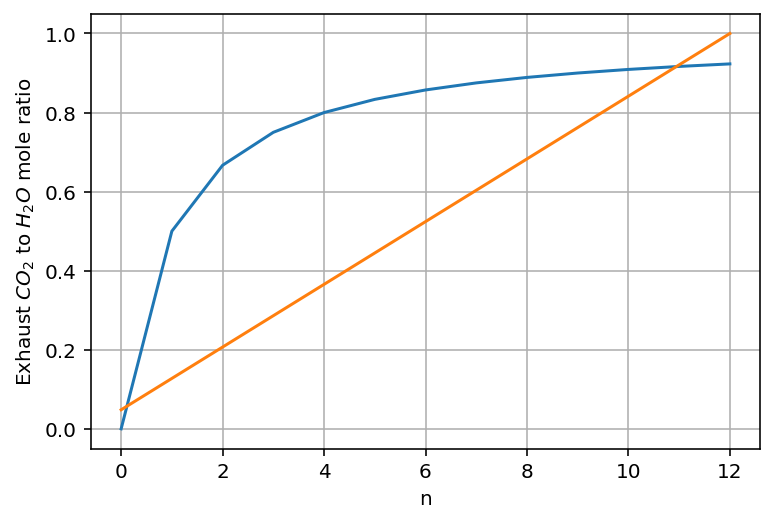

In [ ]:
# Atoms of carbon per fuel molecule
n = np.linspace(0,12,13)

lhv_MJ_kmol = pd.DataFrame(index=np.linspace(0,12,13), 
                         data=[119.96*2, 802.34, 1437.2, 2044.2, 2659.3, 3272.6,
                               3856.7, 4465.8, 5074.9, 5683.3, 6294.5,
                               6098.0, 7519.6])

nbase = 12
mbase = {'H2O': nbase + 1, 'CO2': nbase}
EFbase = {'H2O': 57, 'CO2': 34}

# Effective radiative forcing normalized by the baseline
def EF_norm(nCO2, nH2O):
  return ( nH2O/mbase['H2O']*EFbase['H2O'] + nCO2/mbase['CO2']*EFbase['CO2'] 
          ) / (EFbase['H2O'] + EFbase['CO2'])

# Exhaust CO2 to H2O mole ratio
CO2_H2O_mole_ratio = lambda n: n/(n+1)

fig, ax = plt.subplots()
ax.plot(n, list(map(CO2_H2O_mole_ratio,n)), [EF_norm(m, m+1) for m in n])
ax.set_xlabel('n')
ax.set_ylabel('Exhaust $CO_2$ to $H_2O$ mole ratio')
ax.grid()
